# Cleaning The Dataset

In the previous steps we downloaded economic, currency, and SPY index data and combined it all into a single file. In this step we will clean that dataset in preparation for Exploratory Data Analysis and Feature Engineering.



In [1]:
import pandas as pd

df = pd.read_csv("../../data/generated/fully_combined_finance_data.csv")
df.head()

,date,comodities__DHHNGSP__DHHNGSP,comodities__fredgraph__DCOILBRENTEU,comodities__fredgraph__MHHNGSP,comodities__DCOILWTICO__DCOILWTICO,interest_&_credit__DGS10__DGS10,interest_&_credit__DGS2__DGS2,interest_&_credit__CPN3M__CPN3M,interest_&_credit__DGS1__DGS1,interest_&_credit__DGS5__DGS5,...,SPY_vwap,SPY_transactions,FX_AUDUSD_close,FX_EURUSD_close,FX_GBPUSD_close,FX_NZDUSD_close,FX_USDCAD_close,FX_USDCHF_close,FX_USDJPY_close,FX_USDSEK_close
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.690002,NaN
1,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.139999,NaN
2,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.089996,NaN
3,2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.230003,NaN
4,2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.330002,NaN


#### Step 1: Trim Dataset

Since we know the data downloaded on the SPY index and Foreign Currencies only extends 5 years into the past, lets drop everything older than 6 years. We keep the extra year as padding for a forward filling stilling step to reduce number of rows from this 5 year period we remove. 

In [2]:
df["date"] = pd.to_datetime(df["date"])
cutoff = pd.Timestamp.today().normalize() - pd.DateOffset(years=6)
df = df[df["date"] >= cutoff].copy()

print("Rows kept:", len(df), "| Cutoff:", cutoff.date())


Rows kept: 2086 | Cutoff: 2019-09-10


Now lets take a look at the shape of our trimmed dataset. 

We can see the dataset contains 75 columns (features) and 2092 rows (days).

In [3]:
df.shape

(2086, 75)

### Step 2: Identify Missingness

We know that economic information is released at sparse but consistent times. While we are expecting a large number of missing data items in our dataset we expect it to be Missing Not At Random MNAR, in clean consistent blocks inbetween economic releases. 

To help us identify the missingness structure of our dataset we can use a set of missingness heatmaps to visualize the missingness in the features. 

The heatmaps demonstrate:

- SPY and Forex features contain data that is missing consistently due to closed markets on the weekend (as expected).
- market_sentiment_TEDRATE_TEDRATE contains a clean initial block but then all information moving forward is empty, therefore we will need to remove this feature. If we forwad filled it would be inaccurate. 
- housing_&_construction__EXHOSLUSM495S__EXHOSLUSM495S is empty initially and then the data starts to appear in 2024, indicating this is a newer economic indicator and does not extend historically the full 5 years. For this reason we will need to drop it. 
- growth_&_activity__daily,_7-day__IORB demonstrates similar characteristics to housing_&_construction__EXHOSLUSM495S__EXHOSLUSM495S therefore we will need to drop it. 

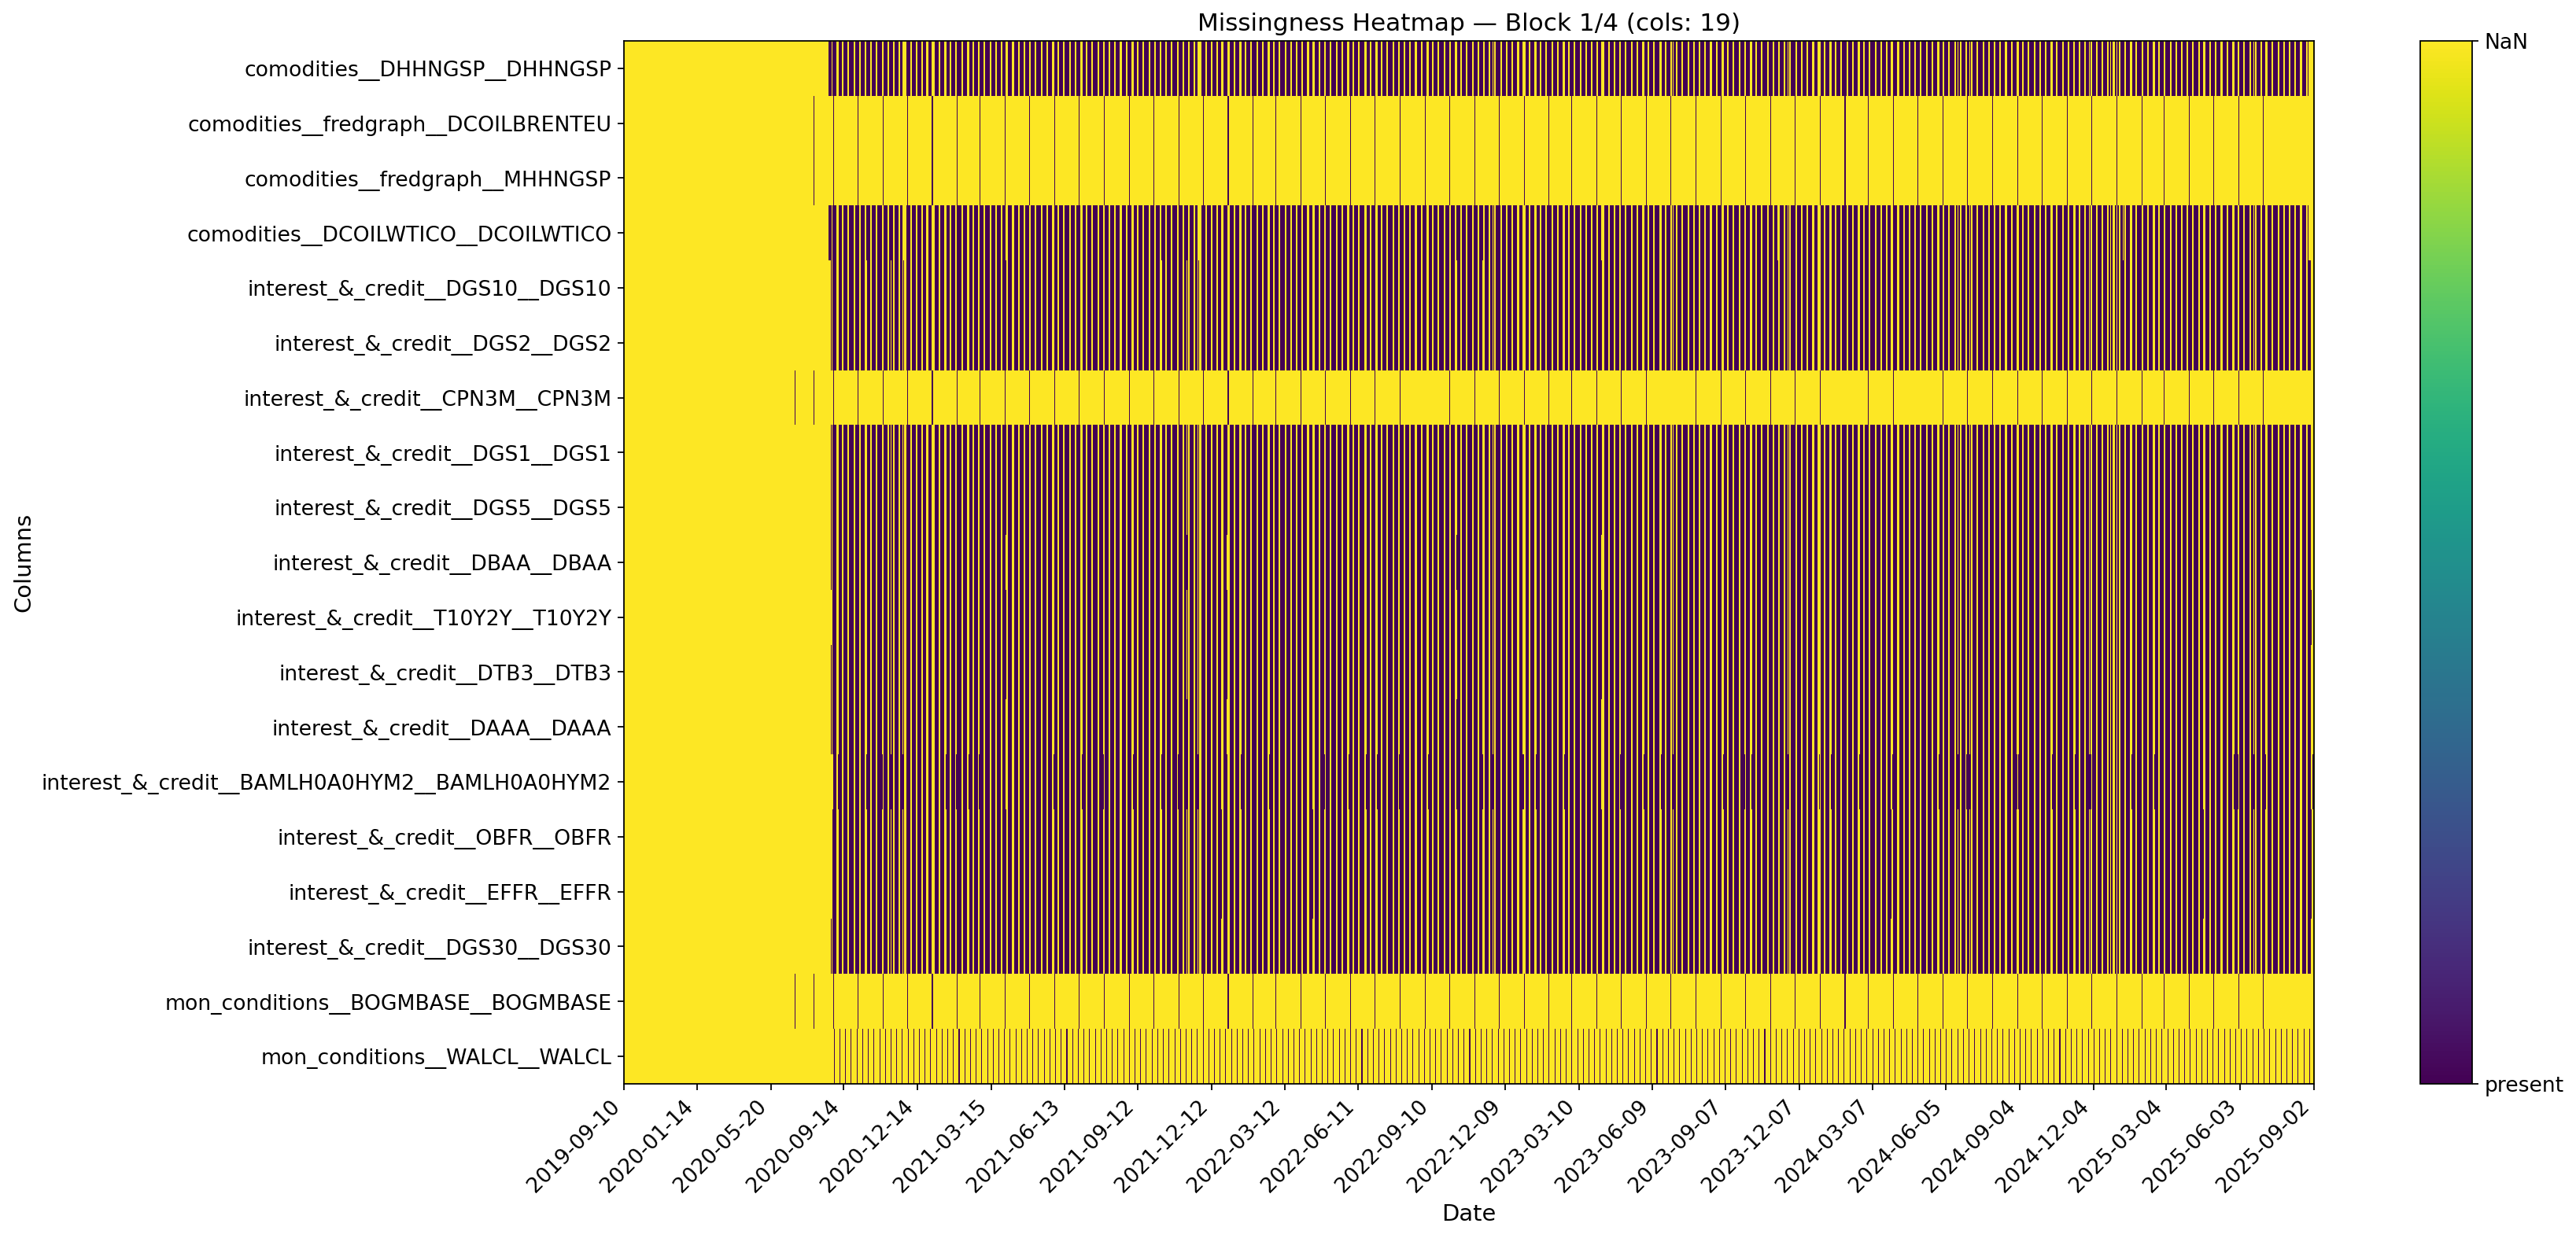

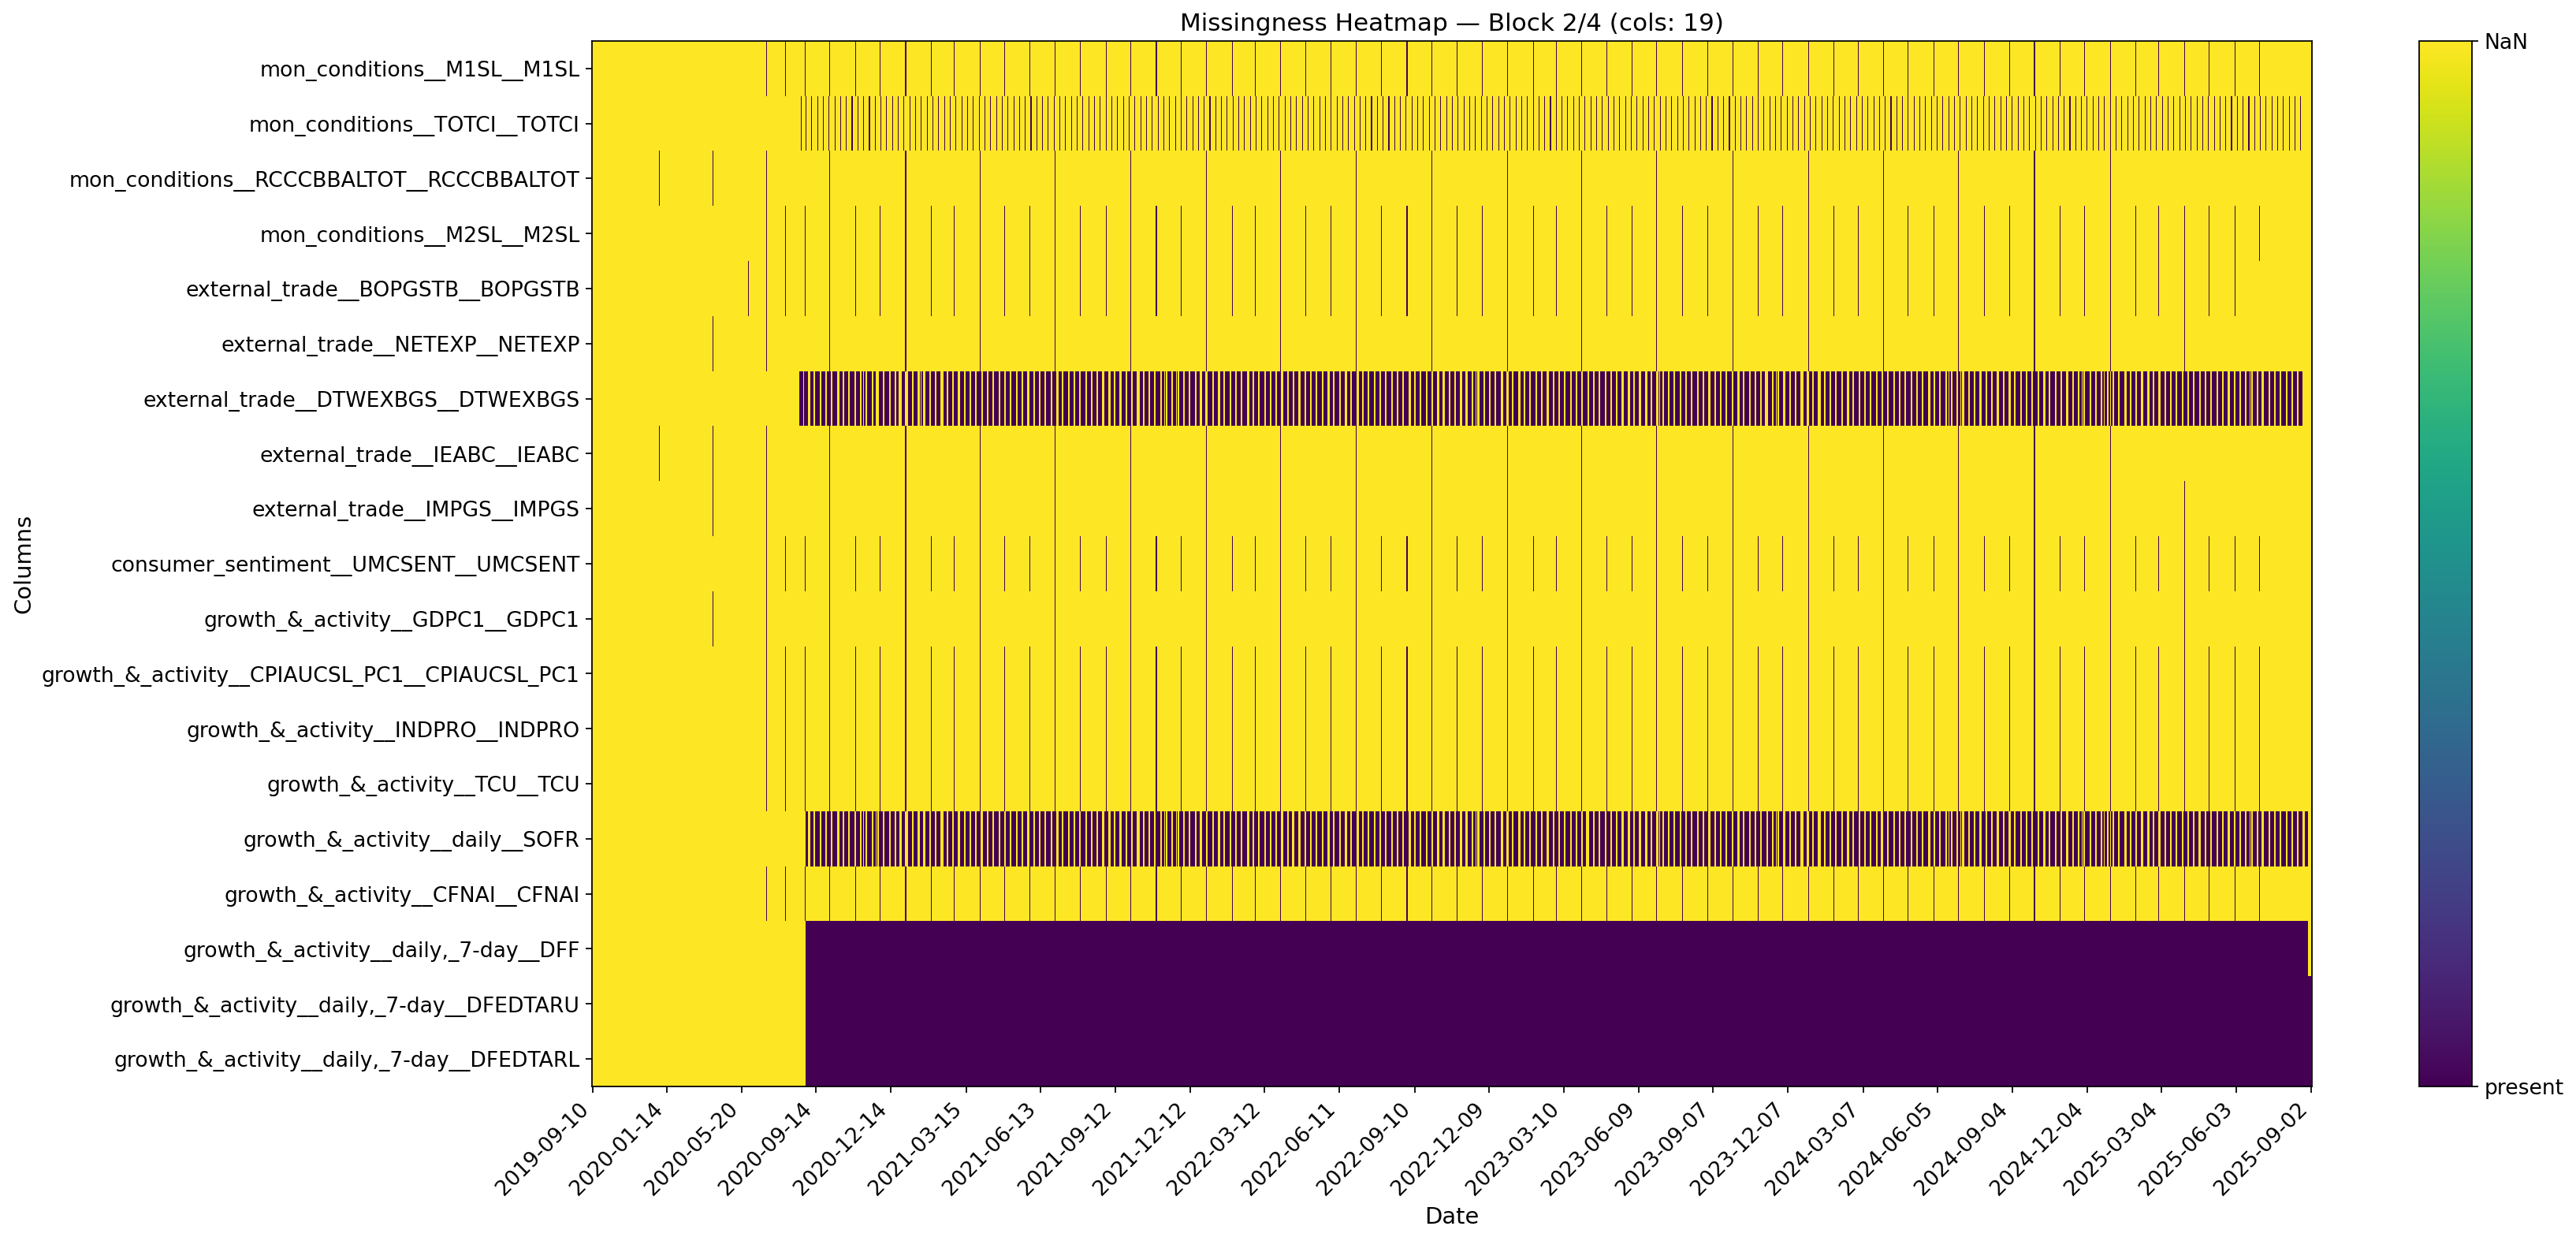

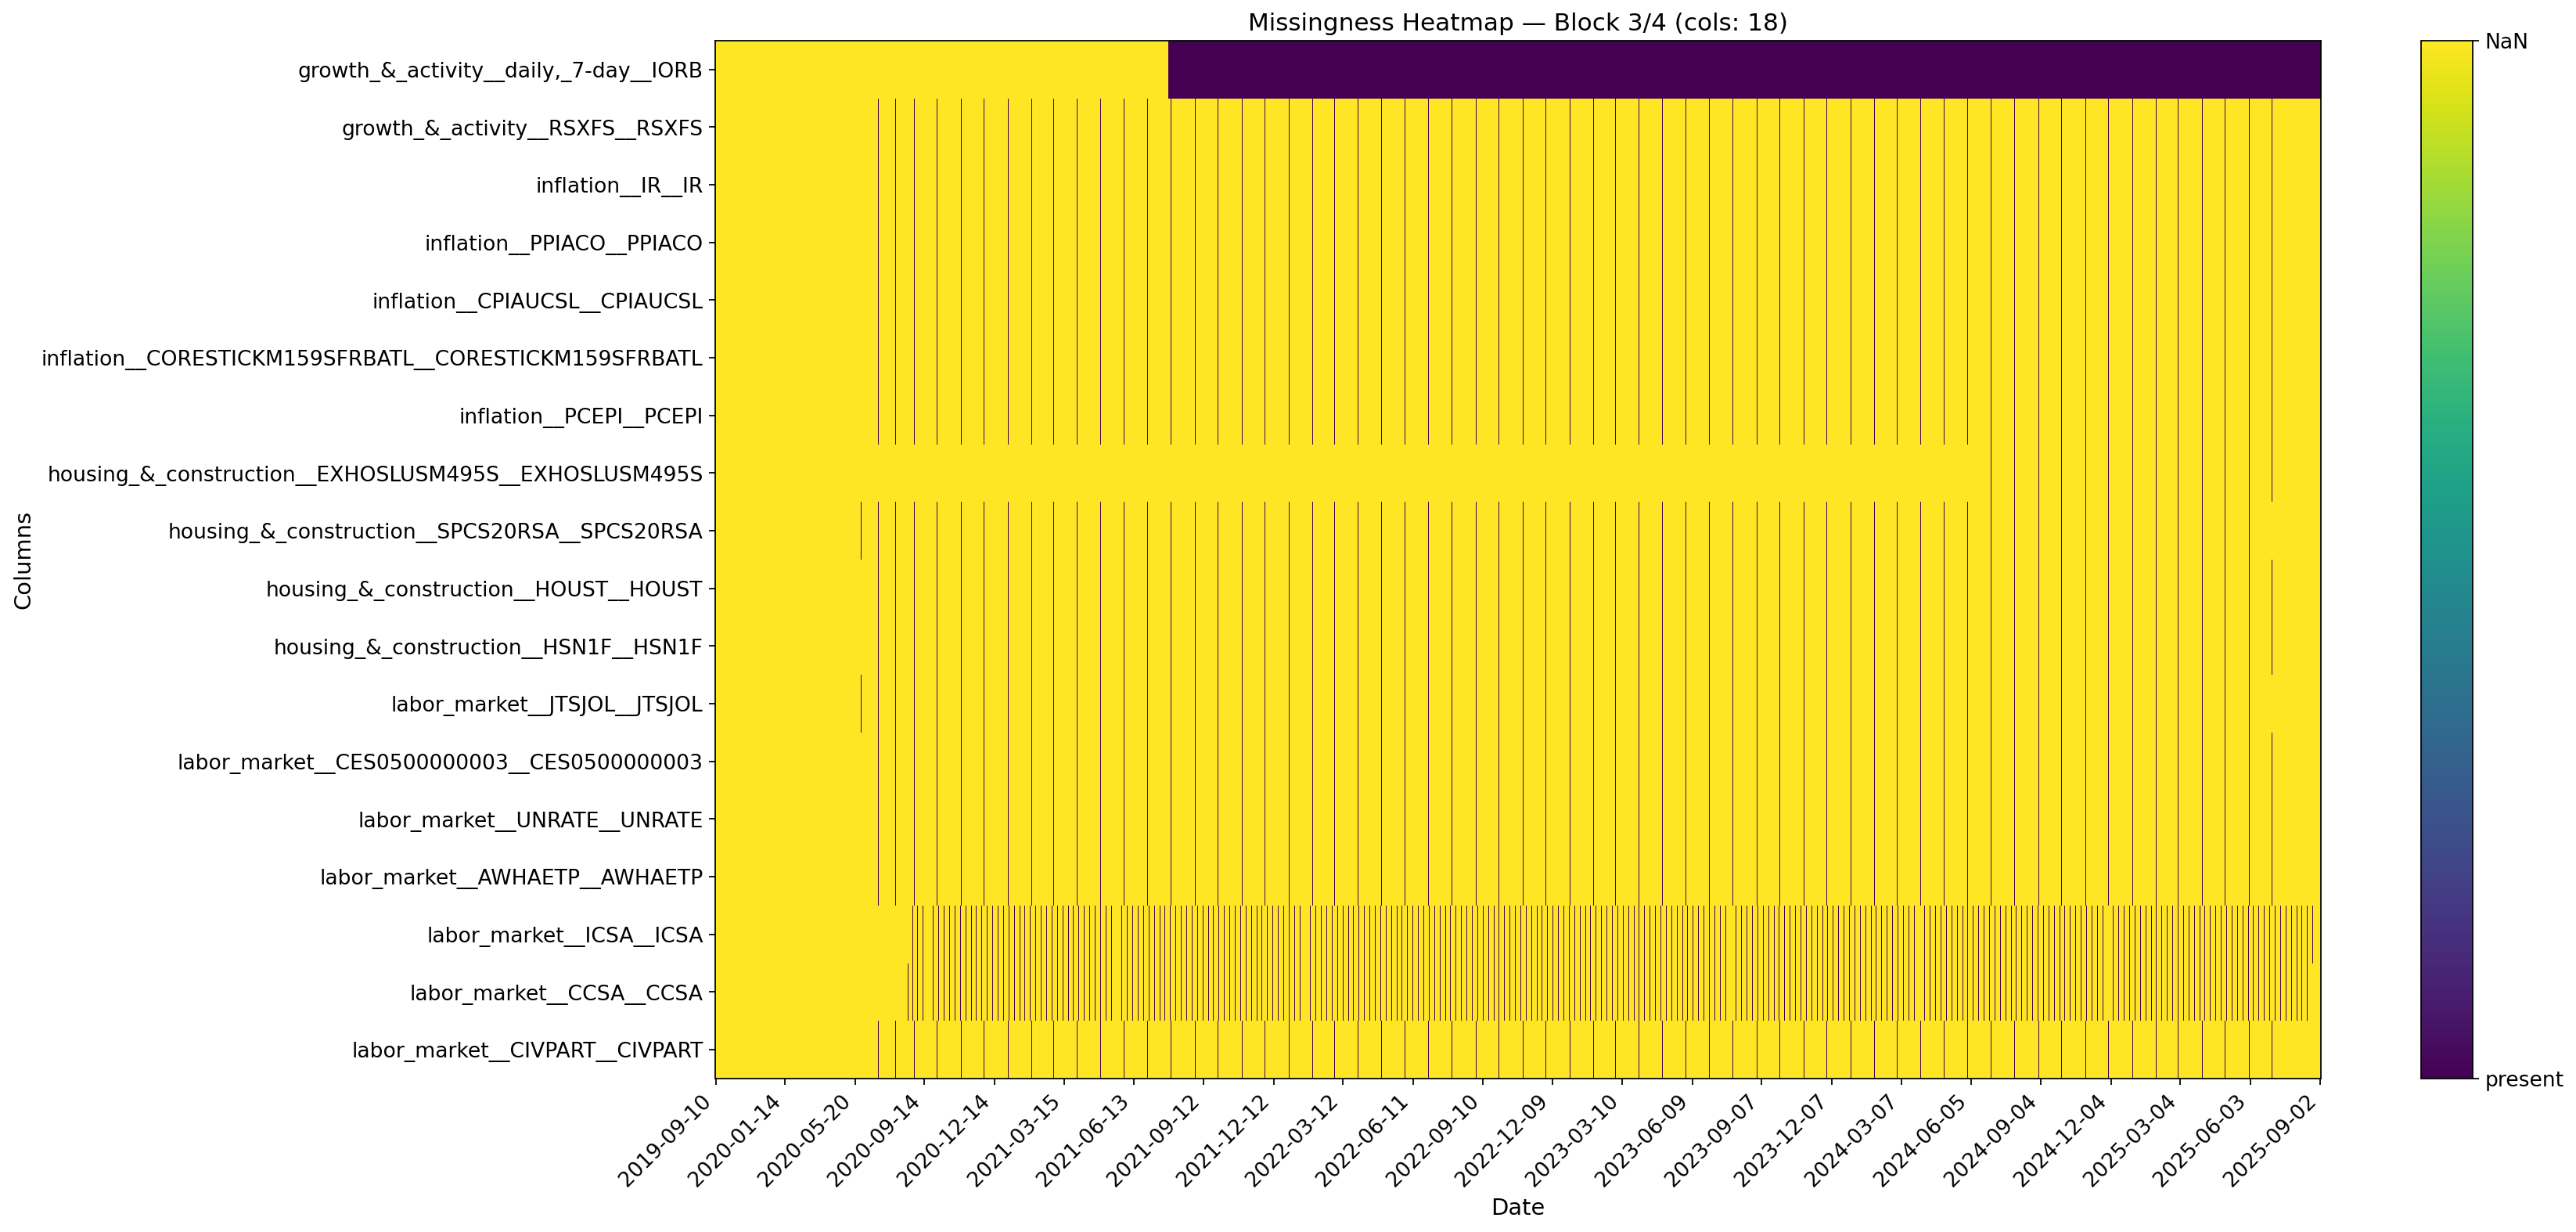

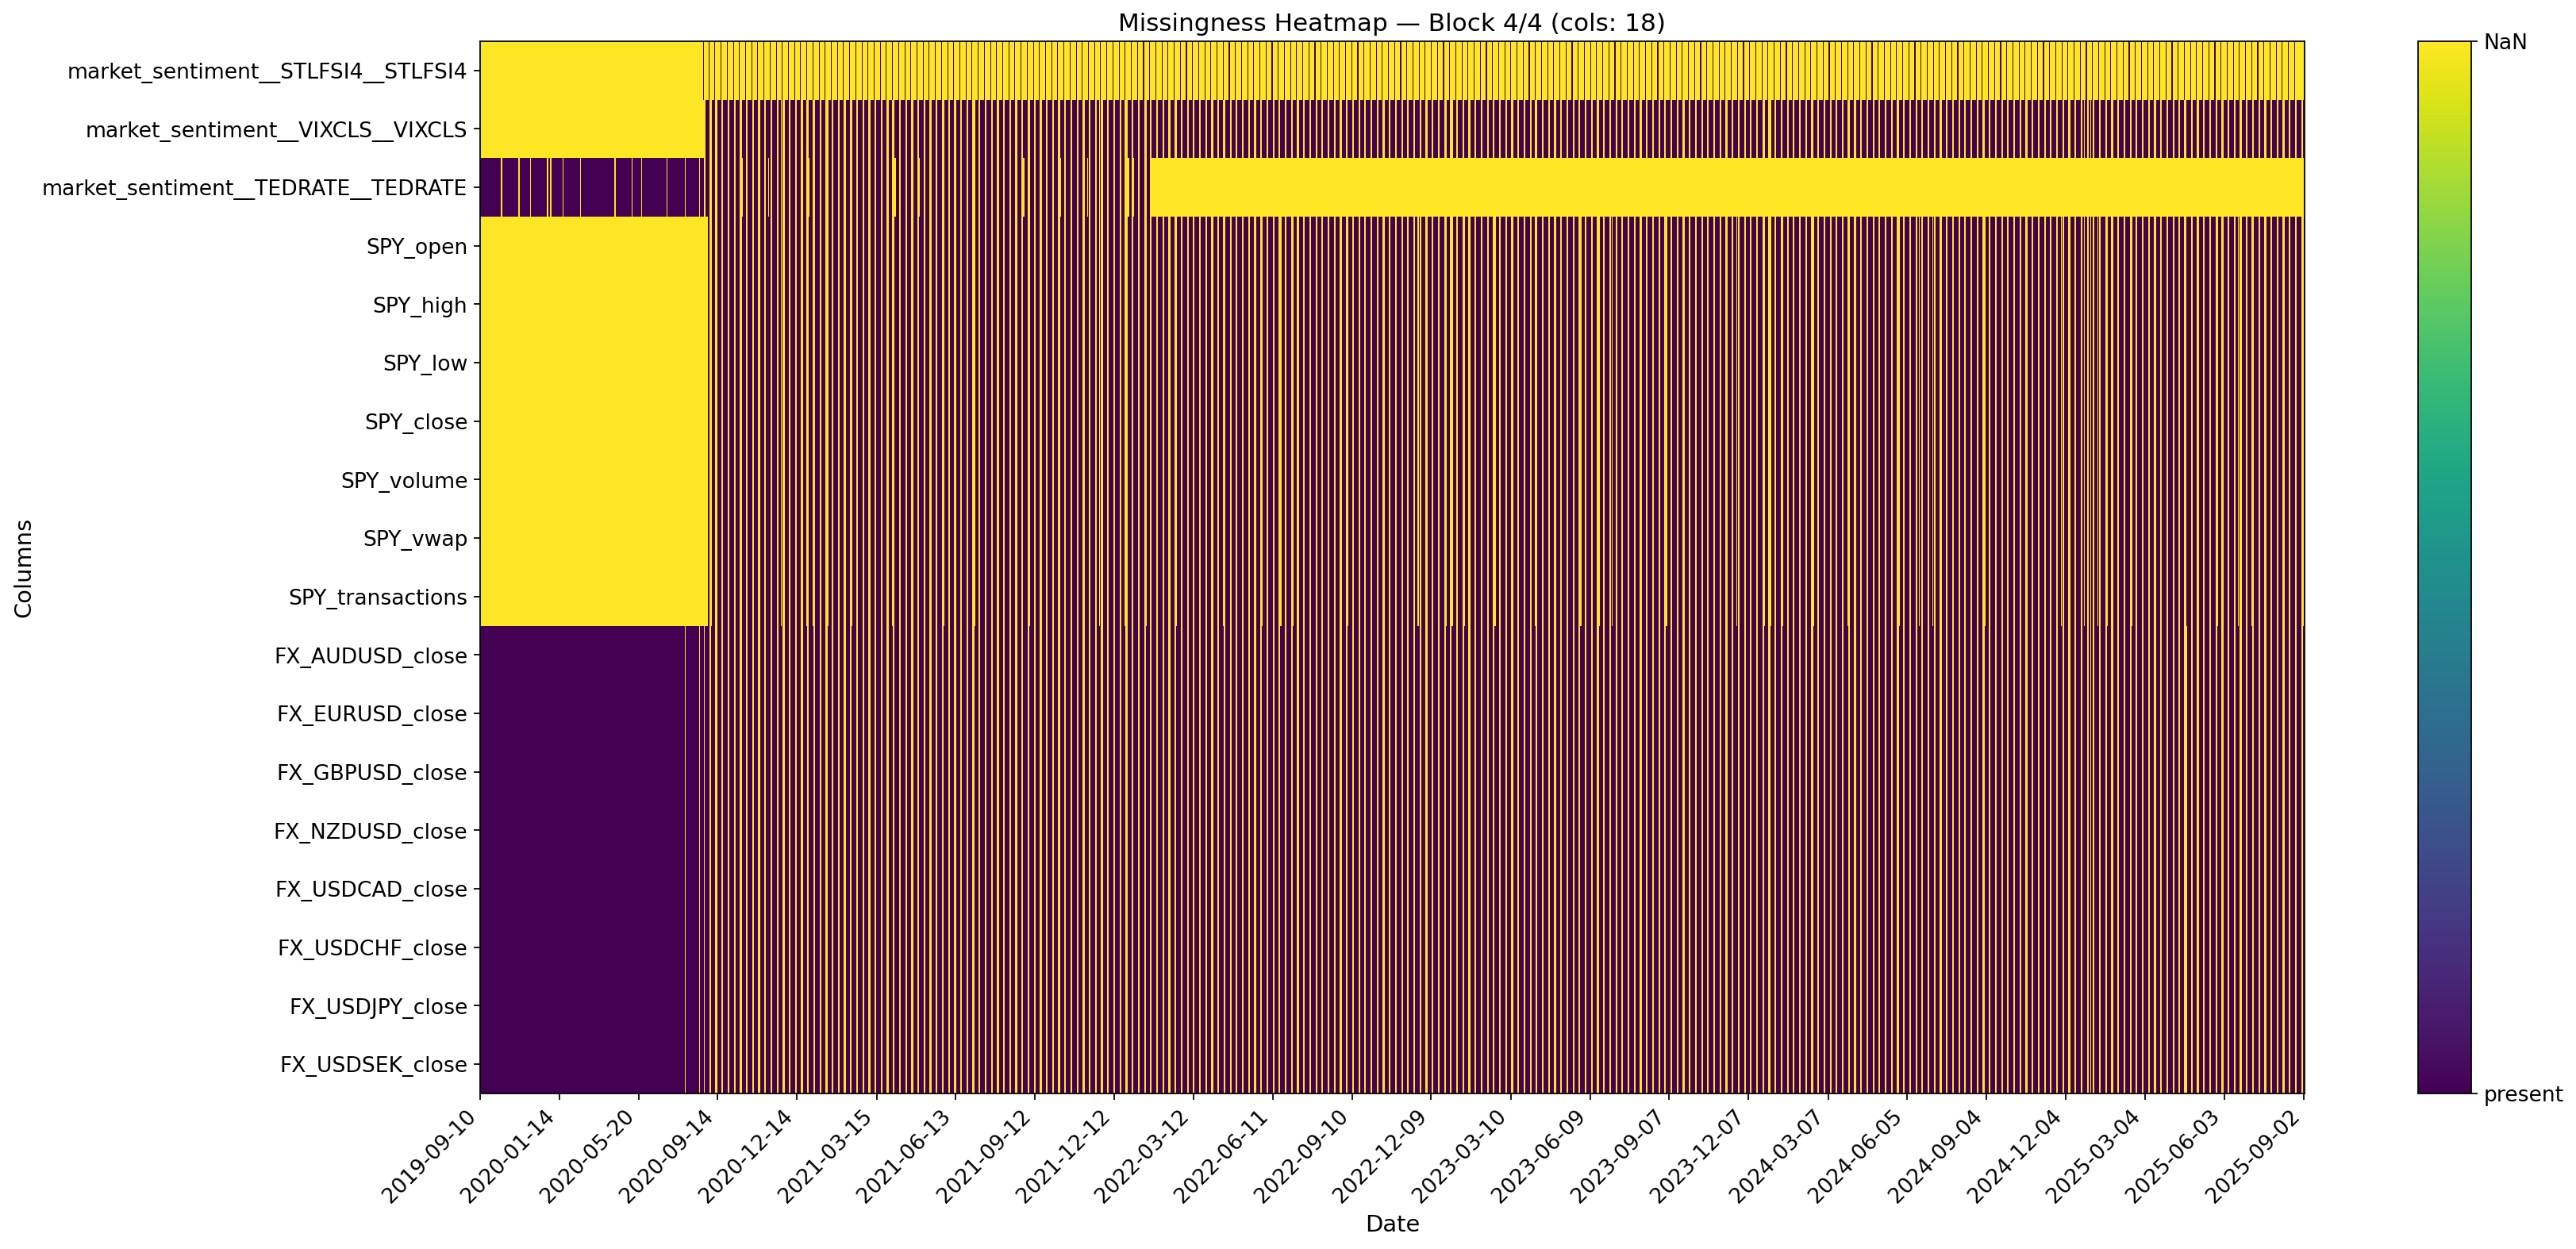

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BLOCKS = 4                     # number of column groups
MAX_XTICKS = 24                # more x ticks for readability
ROW_DOWNSAMPLE = 0             # 0 = no downsample; set to e.g. 2 to take every 2nd row

plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 12

df_plot = df.copy()
if "date" in df_plot.columns:
    df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")
    df_plot = df_plot.dropna(subset=["date"]).set_index("date").sort_index()

mask = df_plot.isna().astype(int)

if ROW_DOWNSAMPLE and ROW_DOWNSAMPLE > 1:
    mask_ds = mask.iloc[::ROW_DOWNSAMPLE, :]
else:
    mask_ds = mask

# split columns into blocks
col_chunks = np.array_split(mask_ds.columns.tolist(), BLOCKS)

for i, cols in enumerate(col_chunks, start=1):
    chunk = mask_ds[cols]
    height = max(10, 0.45 * len(cols))
    plt.figure(figsize=(22, height))  
    plt.imshow(chunk.T, aspect="auto", interpolation="nearest", vmin=0, vmax=1)

    # y ticks = all column names (big figure can handle many)
    plt.yticks(range(len(cols)), cols)

    # x ticks = evenly spaced dates
    num_xticks = min(MAX_XTICKS, len(chunk))
    xtick_pos = np.linspace(0, len(chunk) - 1, num=num_xticks, dtype=int)
    if isinstance(chunk.index, pd.DatetimeIndex):
        xtick_labels = pd.Index(chunk.index[xtick_pos]).strftime("%Y-%m-%d")
    else:
        xtick_labels = chunk.index[xtick_pos].astype(str)
    plt.xticks(xtick_pos, xtick_labels, rotation=45, ha="right")
    plt.tick_params(axis="both", which="major", labelsize=12)

    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Columns", fontsize=13)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["present", "NaN"])
    cbar.ax.tick_params(labelsize=12)

    plt.title(f"Missingness Heatmap — Block {i}/{BLOCKS} (cols: {len(cols)})", fontsize=14)
    plt.tight_layout()
    plt.show()


#### Step 3 Drop Poor Quality Features

As noted in step 2 we will remove:
- housing_&_construction__EXHOSLUSM495S__EXHOSLUSM495S
- market_sentiment__TEDRATE__TEDRATE
- growth_&_activity__daily,_7-day__IORB

In [5]:
import pandas as pd

df = df.copy()
print("Initial Features:", df.shape[1], "\n")
df.columns = df.columns.astype(str).str.strip()

requested = [
    "housing_&_construction__EXHOSLUSM495S__EXHOSLUSM495S",
    "market_sentiment__TEDRATE__TEDRATE",
    "growth_&_activity__daily,_7-day__IORB",
]

# 1) exact matches
exact_present = [c for c in requested if c in df.columns]

# 2) suffix (series code) matches, e.g. "__DFEDTARL"
tokens = [s.split("__")[-1] for s in requested]
tokens_up = [t.upper() for t in tokens]
suffix_matches = [c for c in df.columns if any(c.upper().endswith("__" + t) for t in tokens_up)]

# union to drop
to_drop = sorted(set(exact_present + suffix_matches))
df = df.drop(columns=to_drop, errors="ignore")

print("Dropped:", to_drop)
not_found = [r for r in requested if r not in to_drop]
if not_found:
    print("Requested but not found (no exact/suffix match):", not_found)
print("\nRemaining Features:", df.shape[1])


Initial Features: 75 

Dropped: ['growth_&_activity__daily,_7-day__IORB', 'housing_&_construction__EXHOSLUSM495S__EXHOSLUSM495S', 'market_sentiment__TEDRATE__TEDRATE']

Remaining Features: 72


Revisualize Now that we have removed low quality Features lets revisualize the missingness heatmaps.

From the heatmaps below we can conclude the poor quality data was indeed removed.

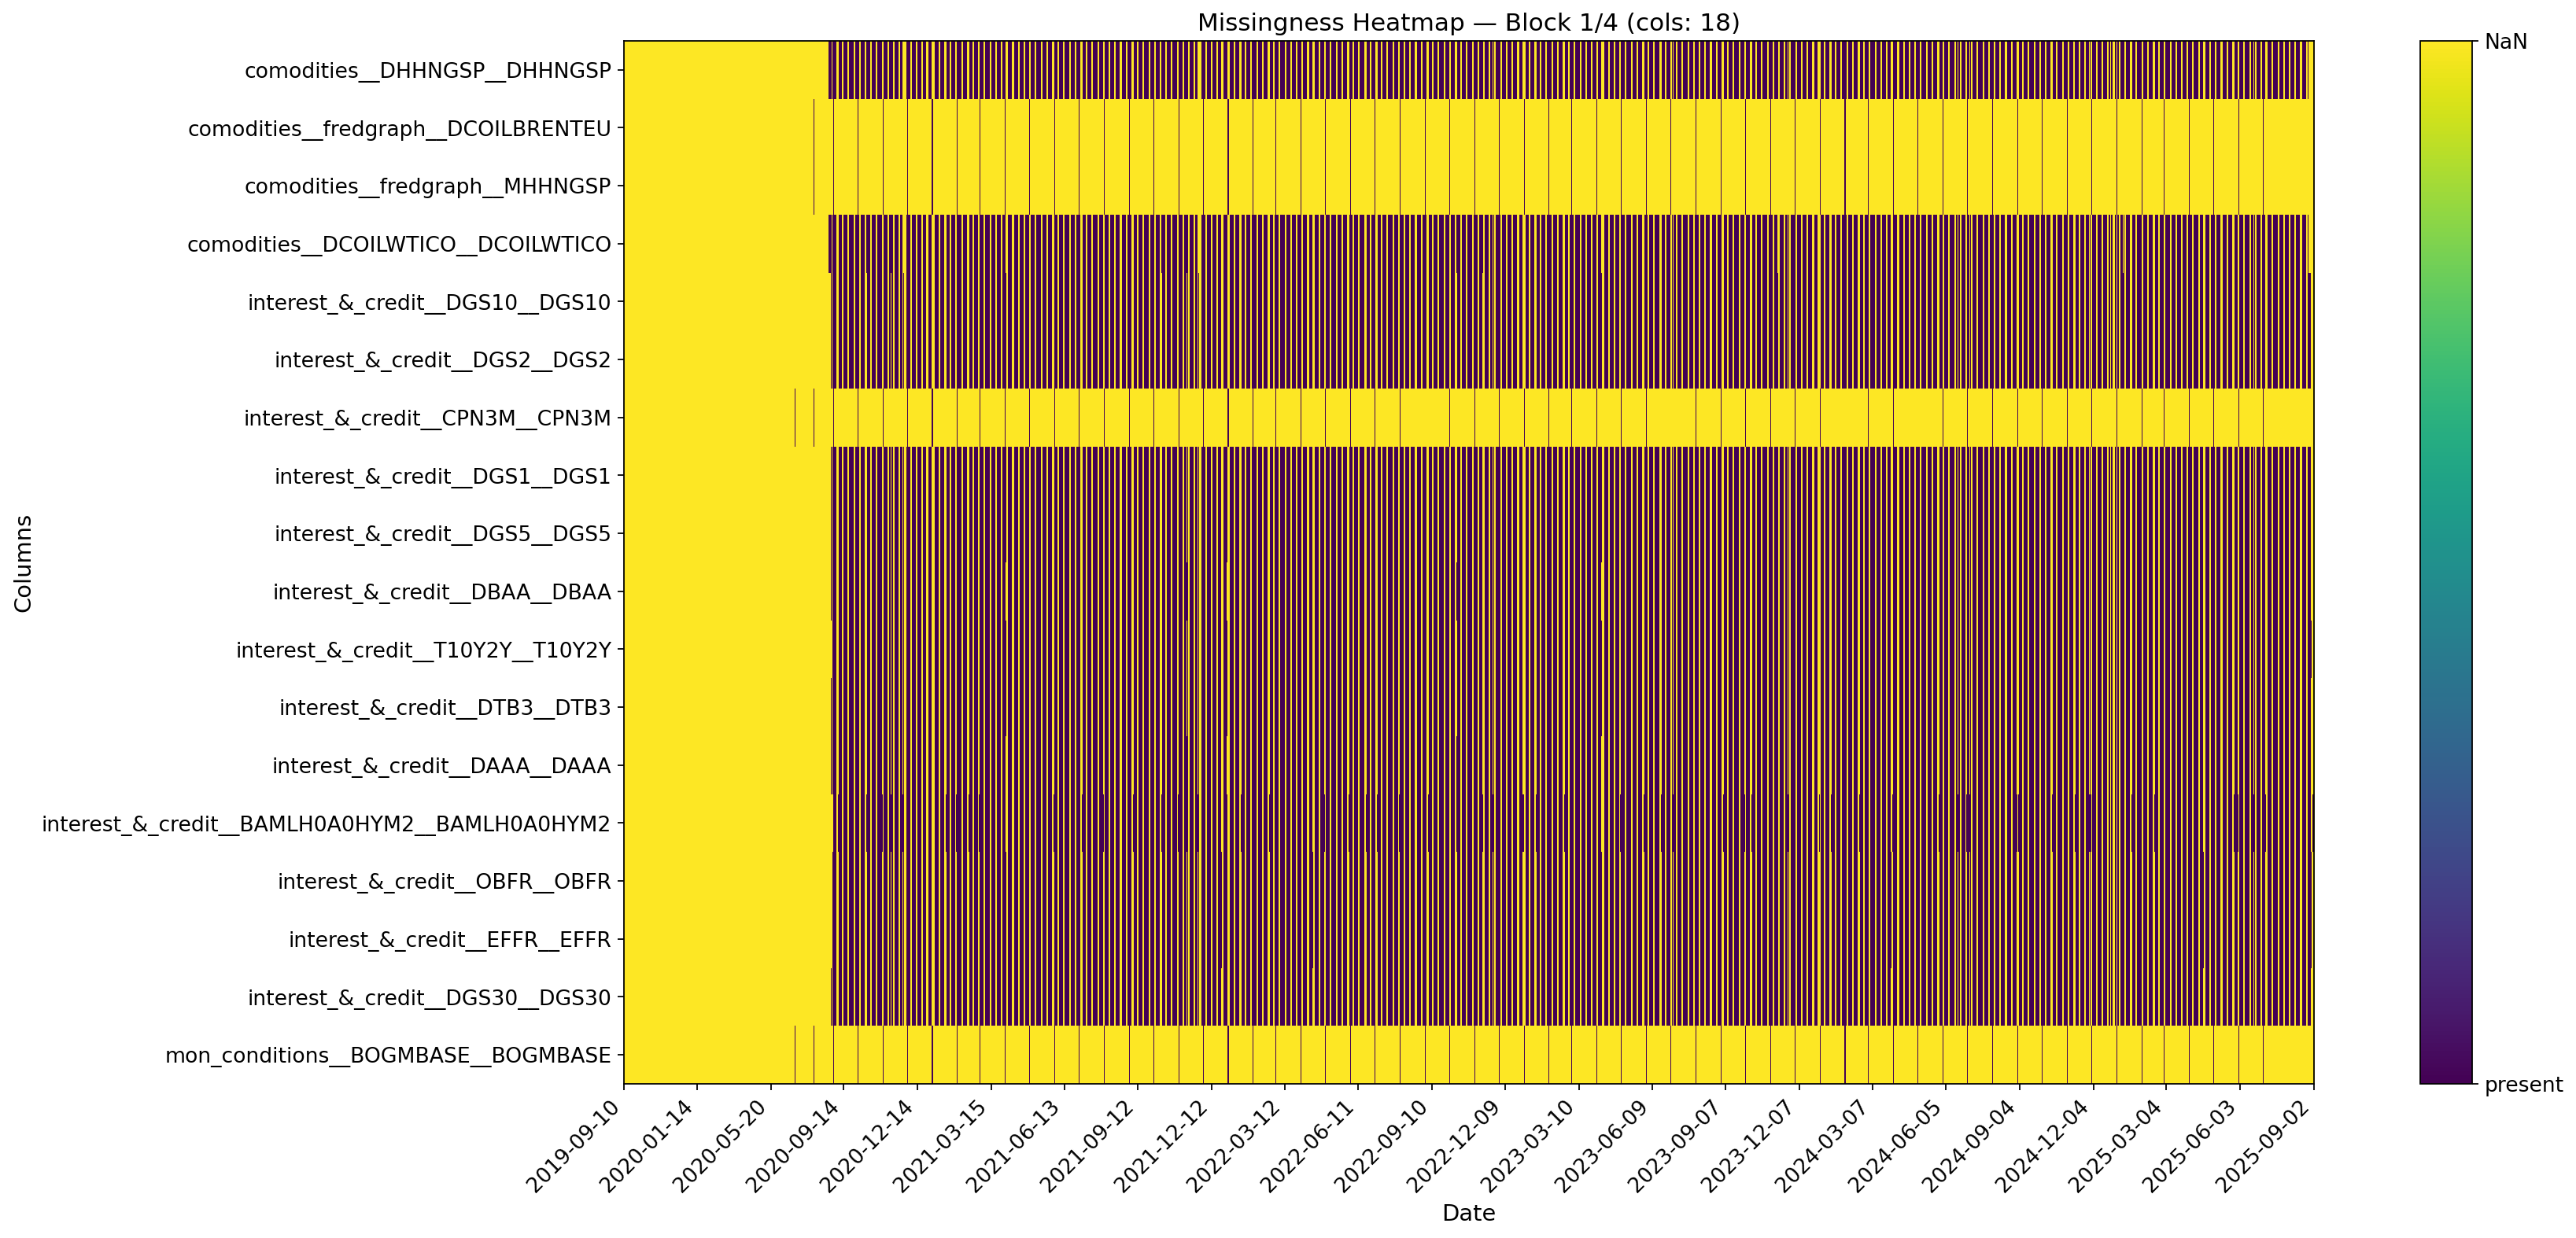

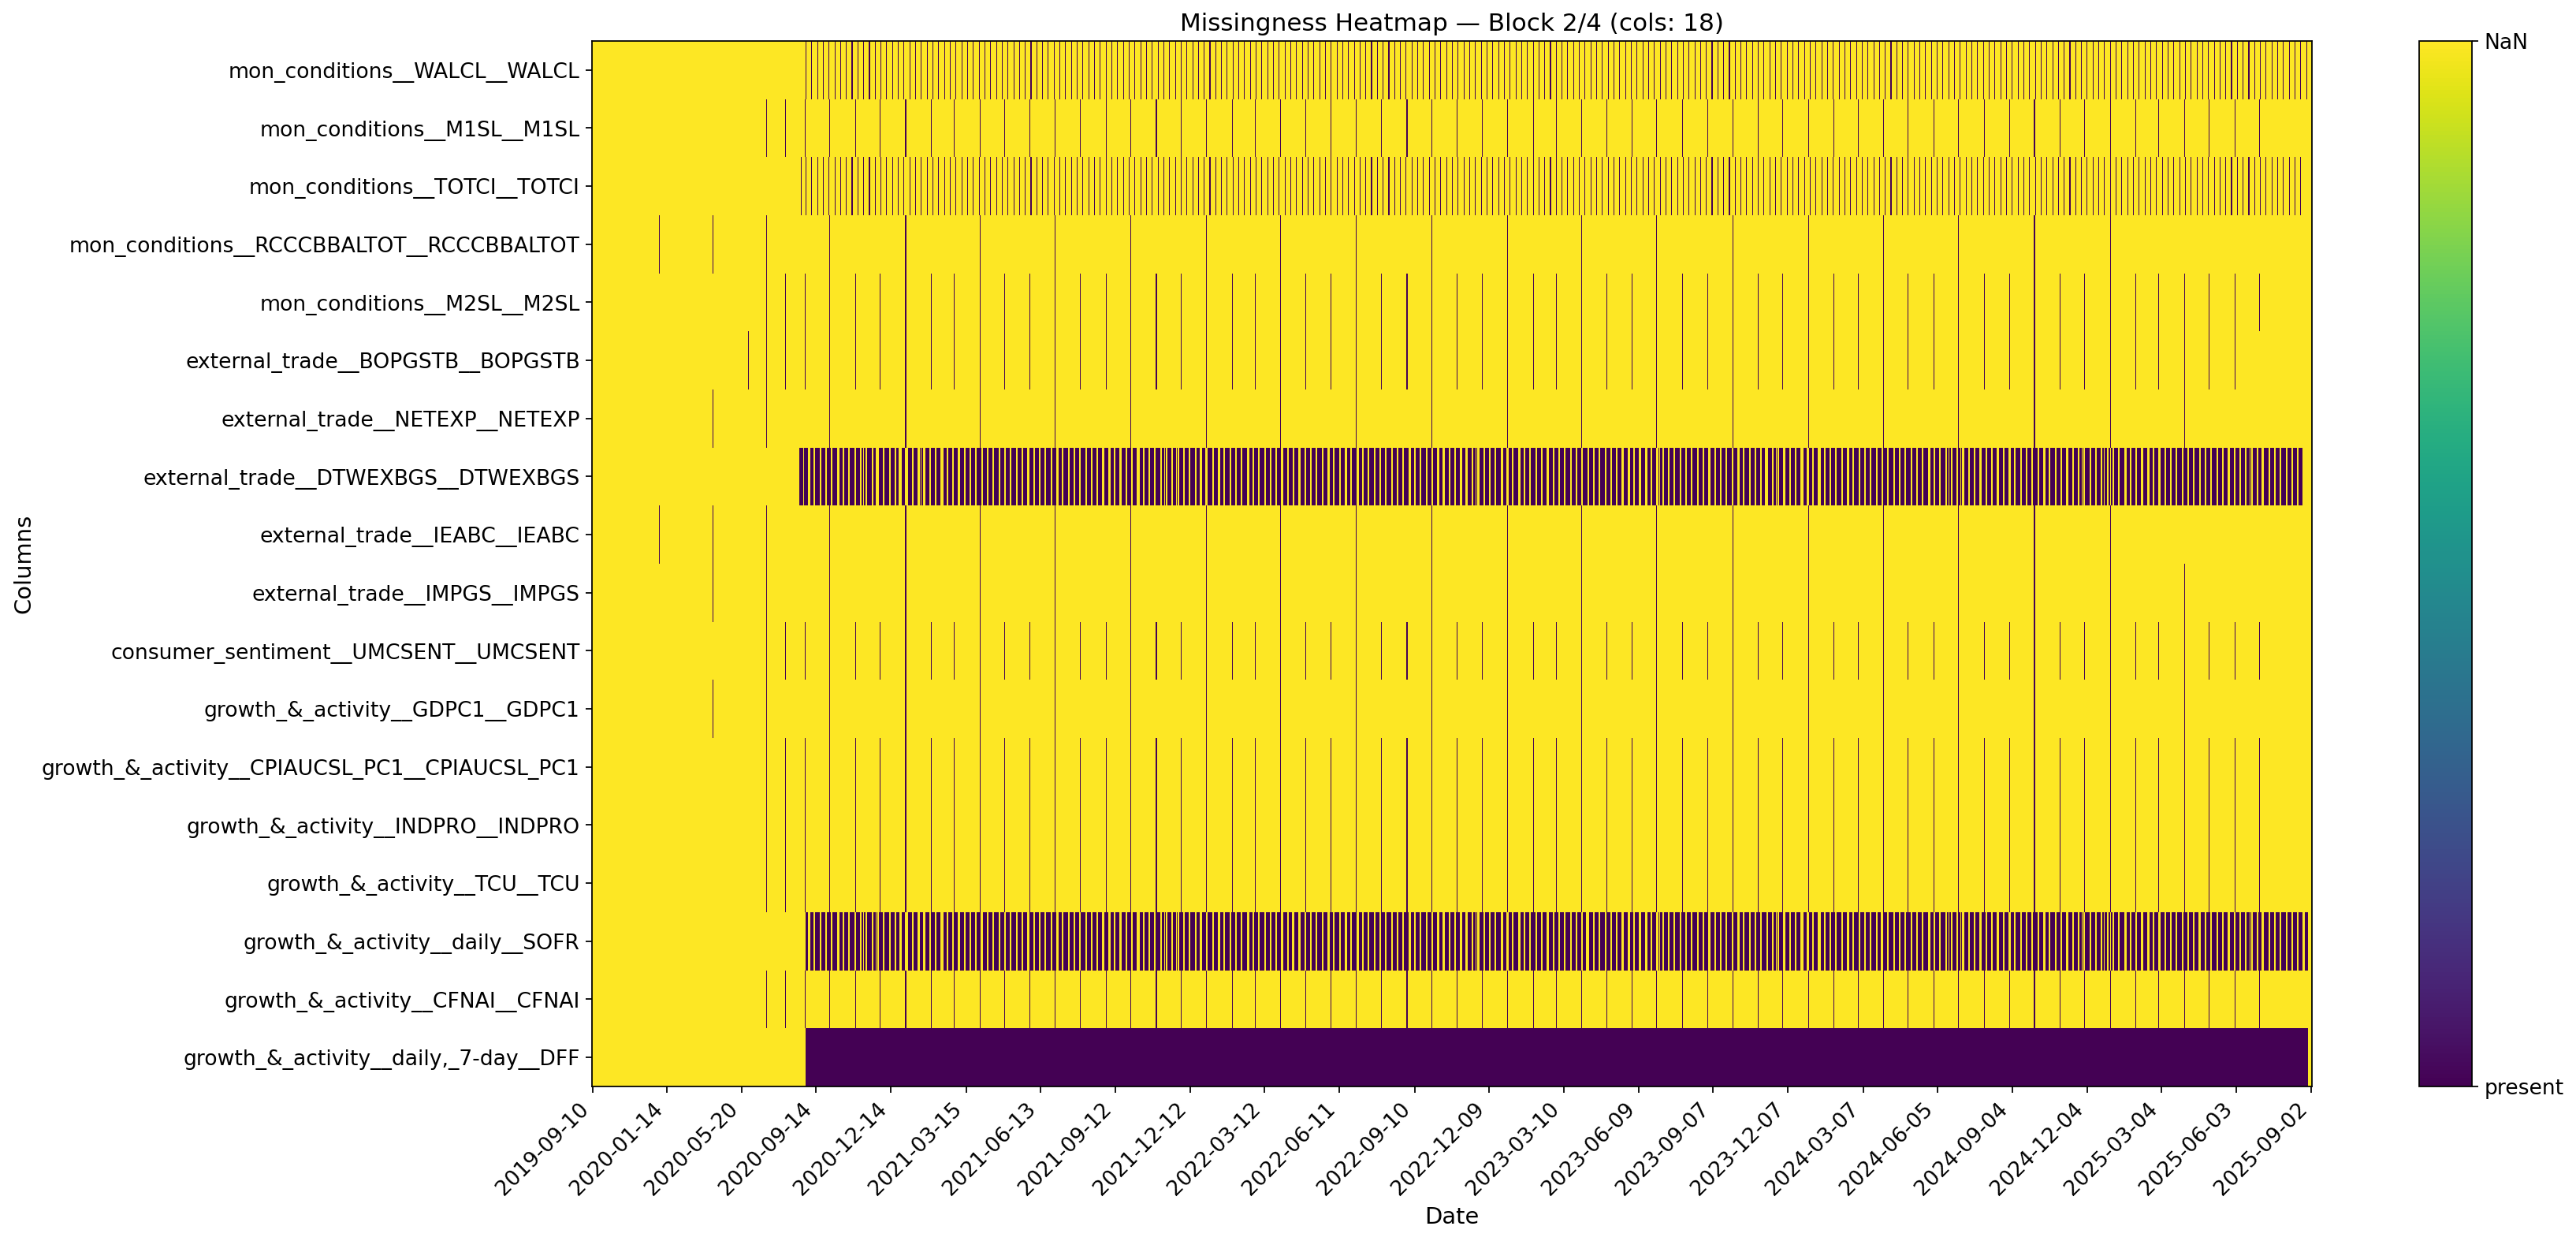

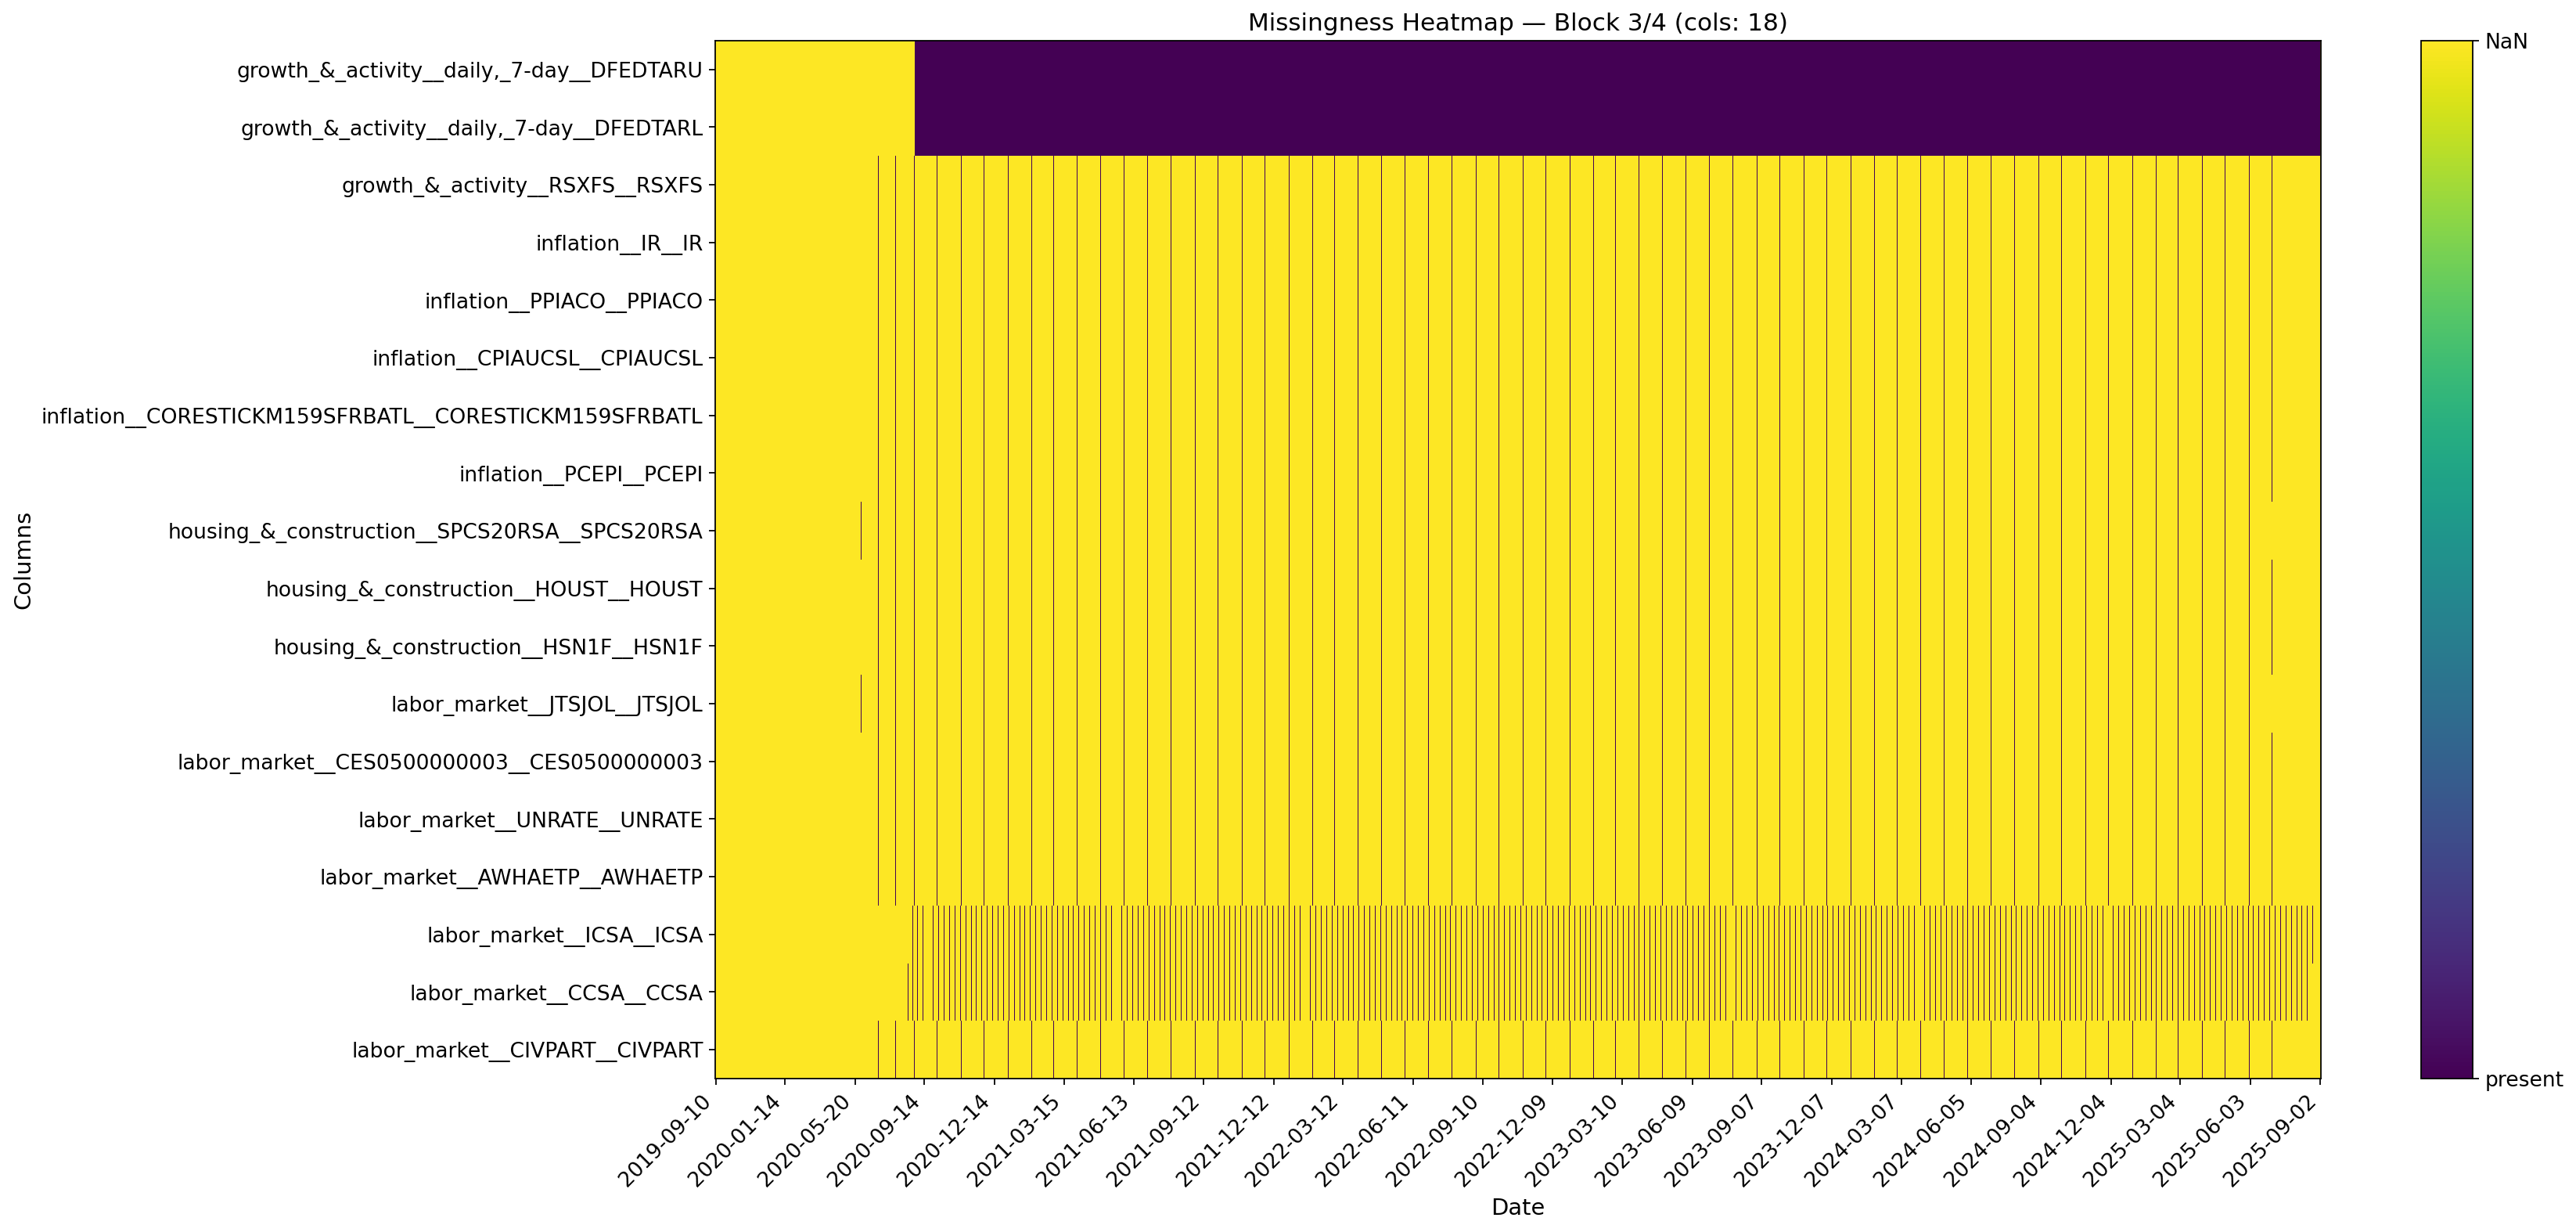

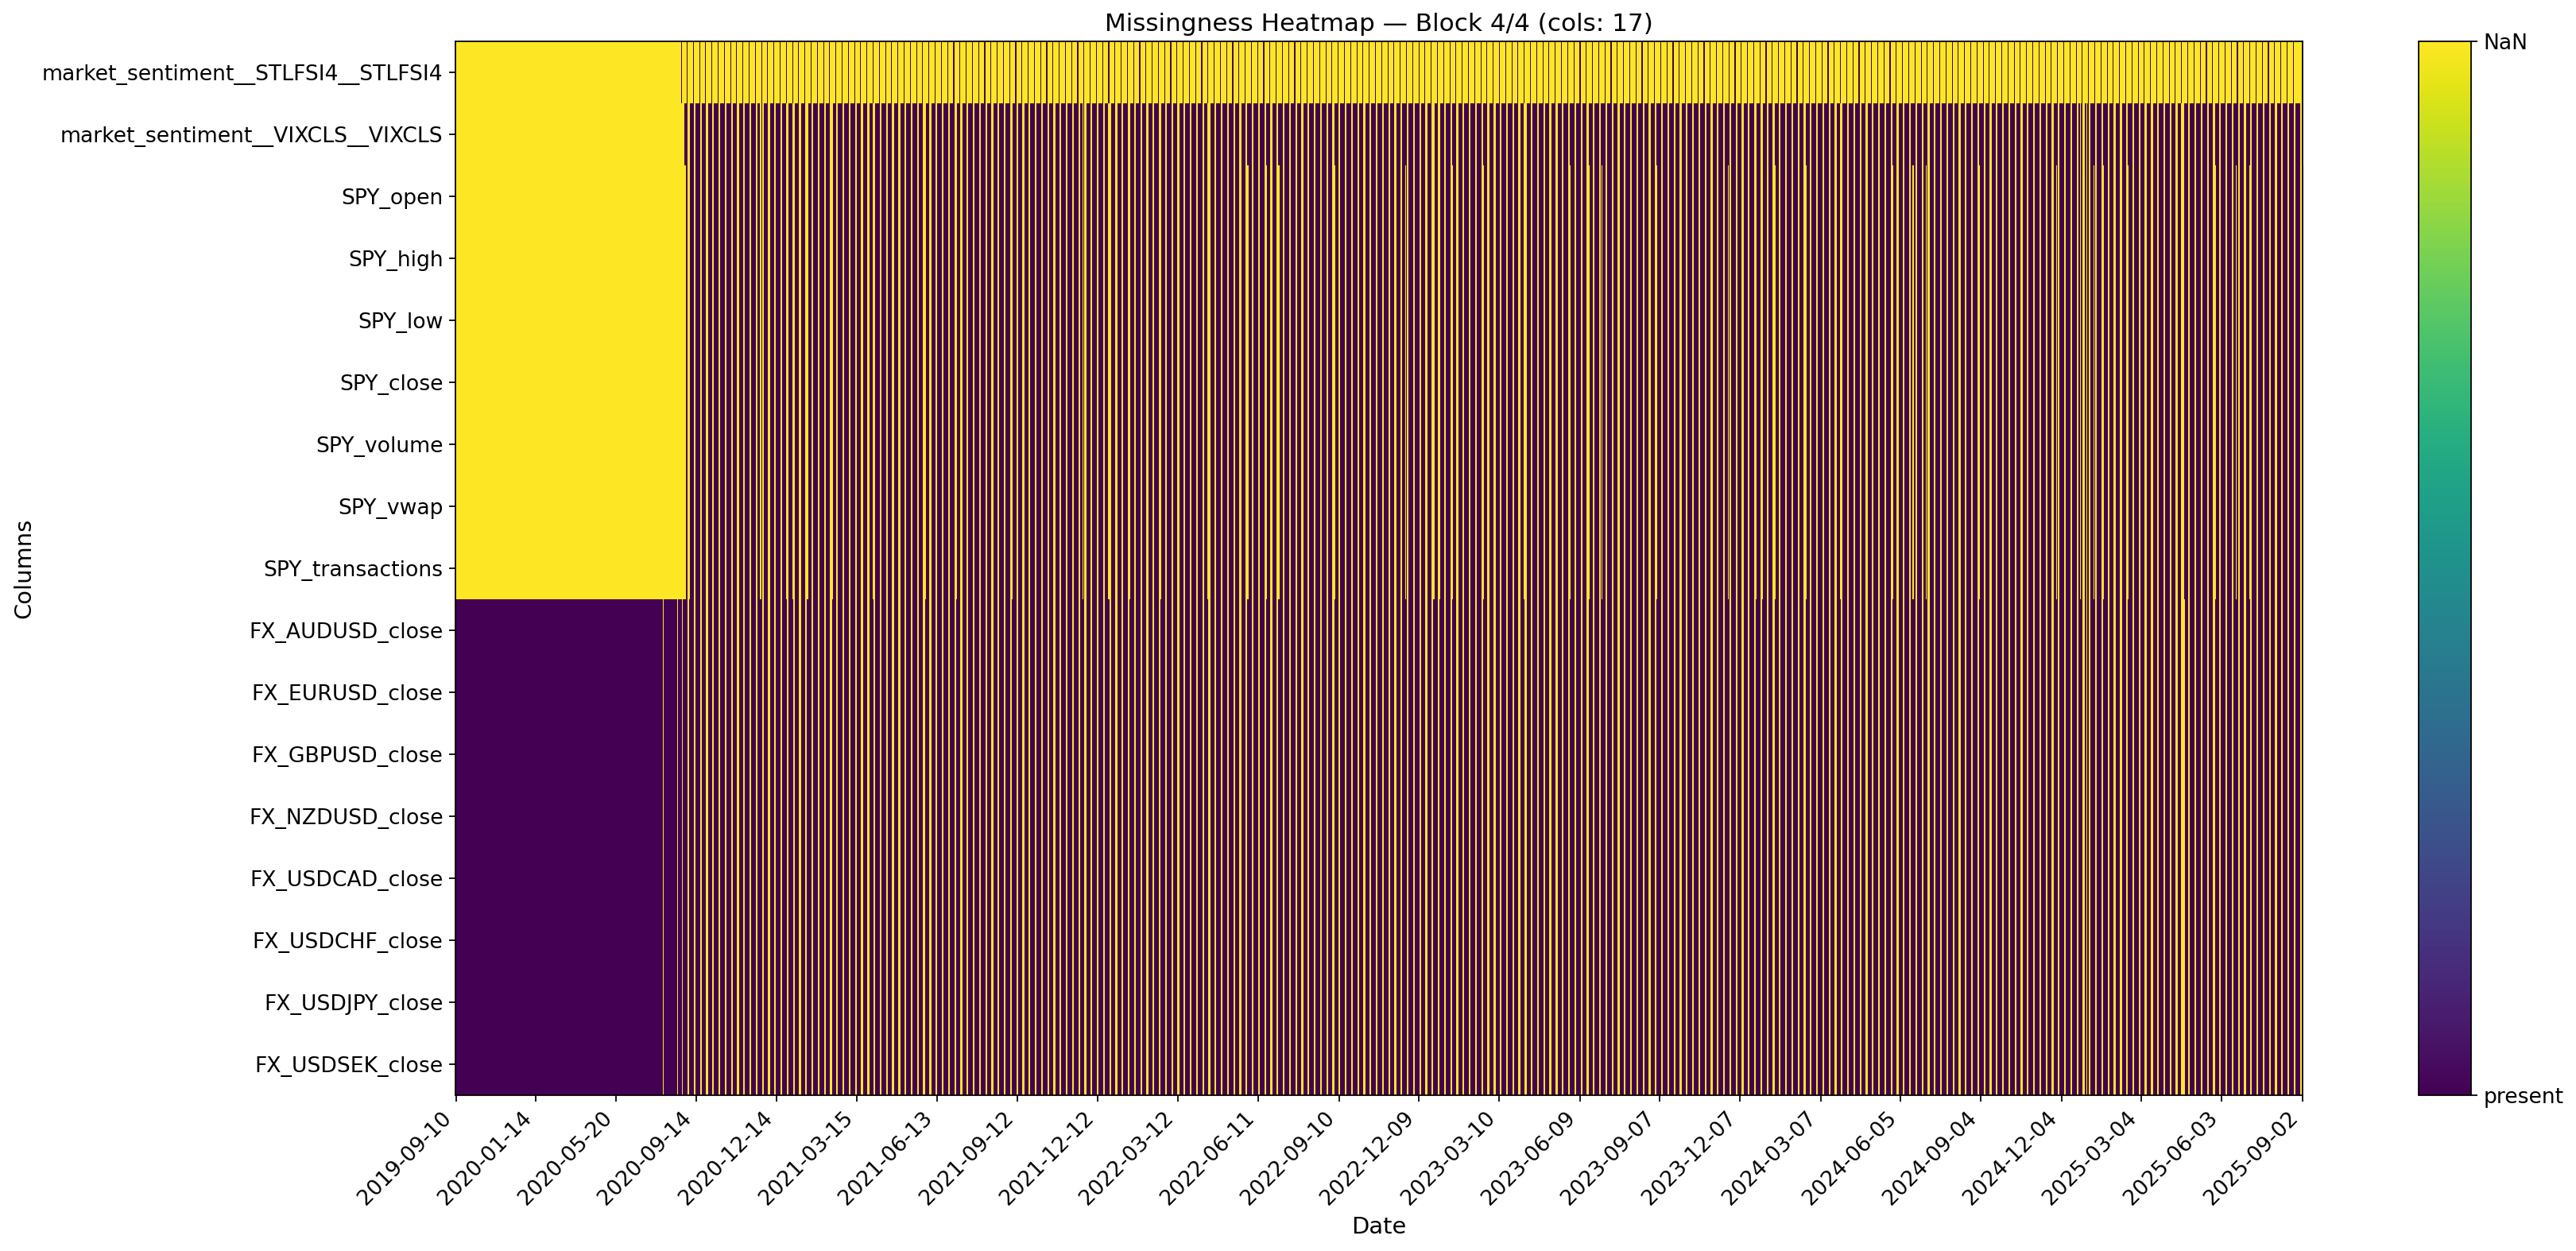

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BLOCKS = 4                     # number of column groups
MAX_XTICKS = 24                # more x ticks for readability
ROW_DOWNSAMPLE = 0             # 0 = no downsample; set to e.g. 2 to take every 2nd row

plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 12

df_plot = df.copy()
if "date" in df_plot.columns:
    df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")
    df_plot = df_plot.dropna(subset=["date"]).set_index("date").sort_index()

mask = df_plot.isna().astype(int)

if ROW_DOWNSAMPLE and ROW_DOWNSAMPLE > 1:
    mask_ds = mask.iloc[::ROW_DOWNSAMPLE, :]
else:
    mask_ds = mask

# split columns into blocks
col_chunks = np.array_split(mask_ds.columns.tolist(), BLOCKS)

for i, cols in enumerate(col_chunks, start=1):
    chunk = mask_ds[cols]
    height = max(10, 0.45 * len(cols))
    plt.figure(figsize=(22, height))  
    plt.imshow(chunk.T, aspect="auto", interpolation="nearest", vmin=0, vmax=1)

    # y ticks = all column names (big figure can handle many)
    plt.yticks(range(len(cols)), cols)

    # x ticks = evenly spaced dates
    num_xticks = min(MAX_XTICKS, len(chunk))
    xtick_pos = np.linspace(0, len(chunk) - 1, num=num_xticks, dtype=int)
    if isinstance(chunk.index, pd.DatetimeIndex):
        xtick_labels = pd.Index(chunk.index[xtick_pos]).strftime("%Y-%m-%d")
    else:
        xtick_labels = chunk.index[xtick_pos].astype(str)
    plt.xticks(xtick_pos, xtick_labels, rotation=45, ha="right")
    plt.tick_params(axis="both", which="major", labelsize=12)

    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Columns", fontsize=13)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["present", "NaN"])
    cbar.ax.tick_params(labelsize=12)

    plt.title(f"Missingness Heatmap — Block {i}/{BLOCKS} (cols: {len(cols)})", fontsize=14)
    plt.tight_layout()
    plt.show()


#### Step 4: Trim Further

We can see that even though the dataset contains quality features, not all data has been released yet for some economic indicators. To ensure high quality training data we will remove a portion of the data from the end of the timeframe so all information is up to date for each feature. This will help wth the forward filling process. 

Lets drop all rows after 2025-04-05.

In [7]:
import pandas as pd

df = df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
cutoff = pd.Timestamp("2025-04-05")
df = df[df["date"] <= cutoff].reset_index(drop=True)

print("Kept through:", cutoff.date(), "| rows:", len(df))


Kept through: 2025-04-05 | rows: 1936


Again, lets visualize these changes. 

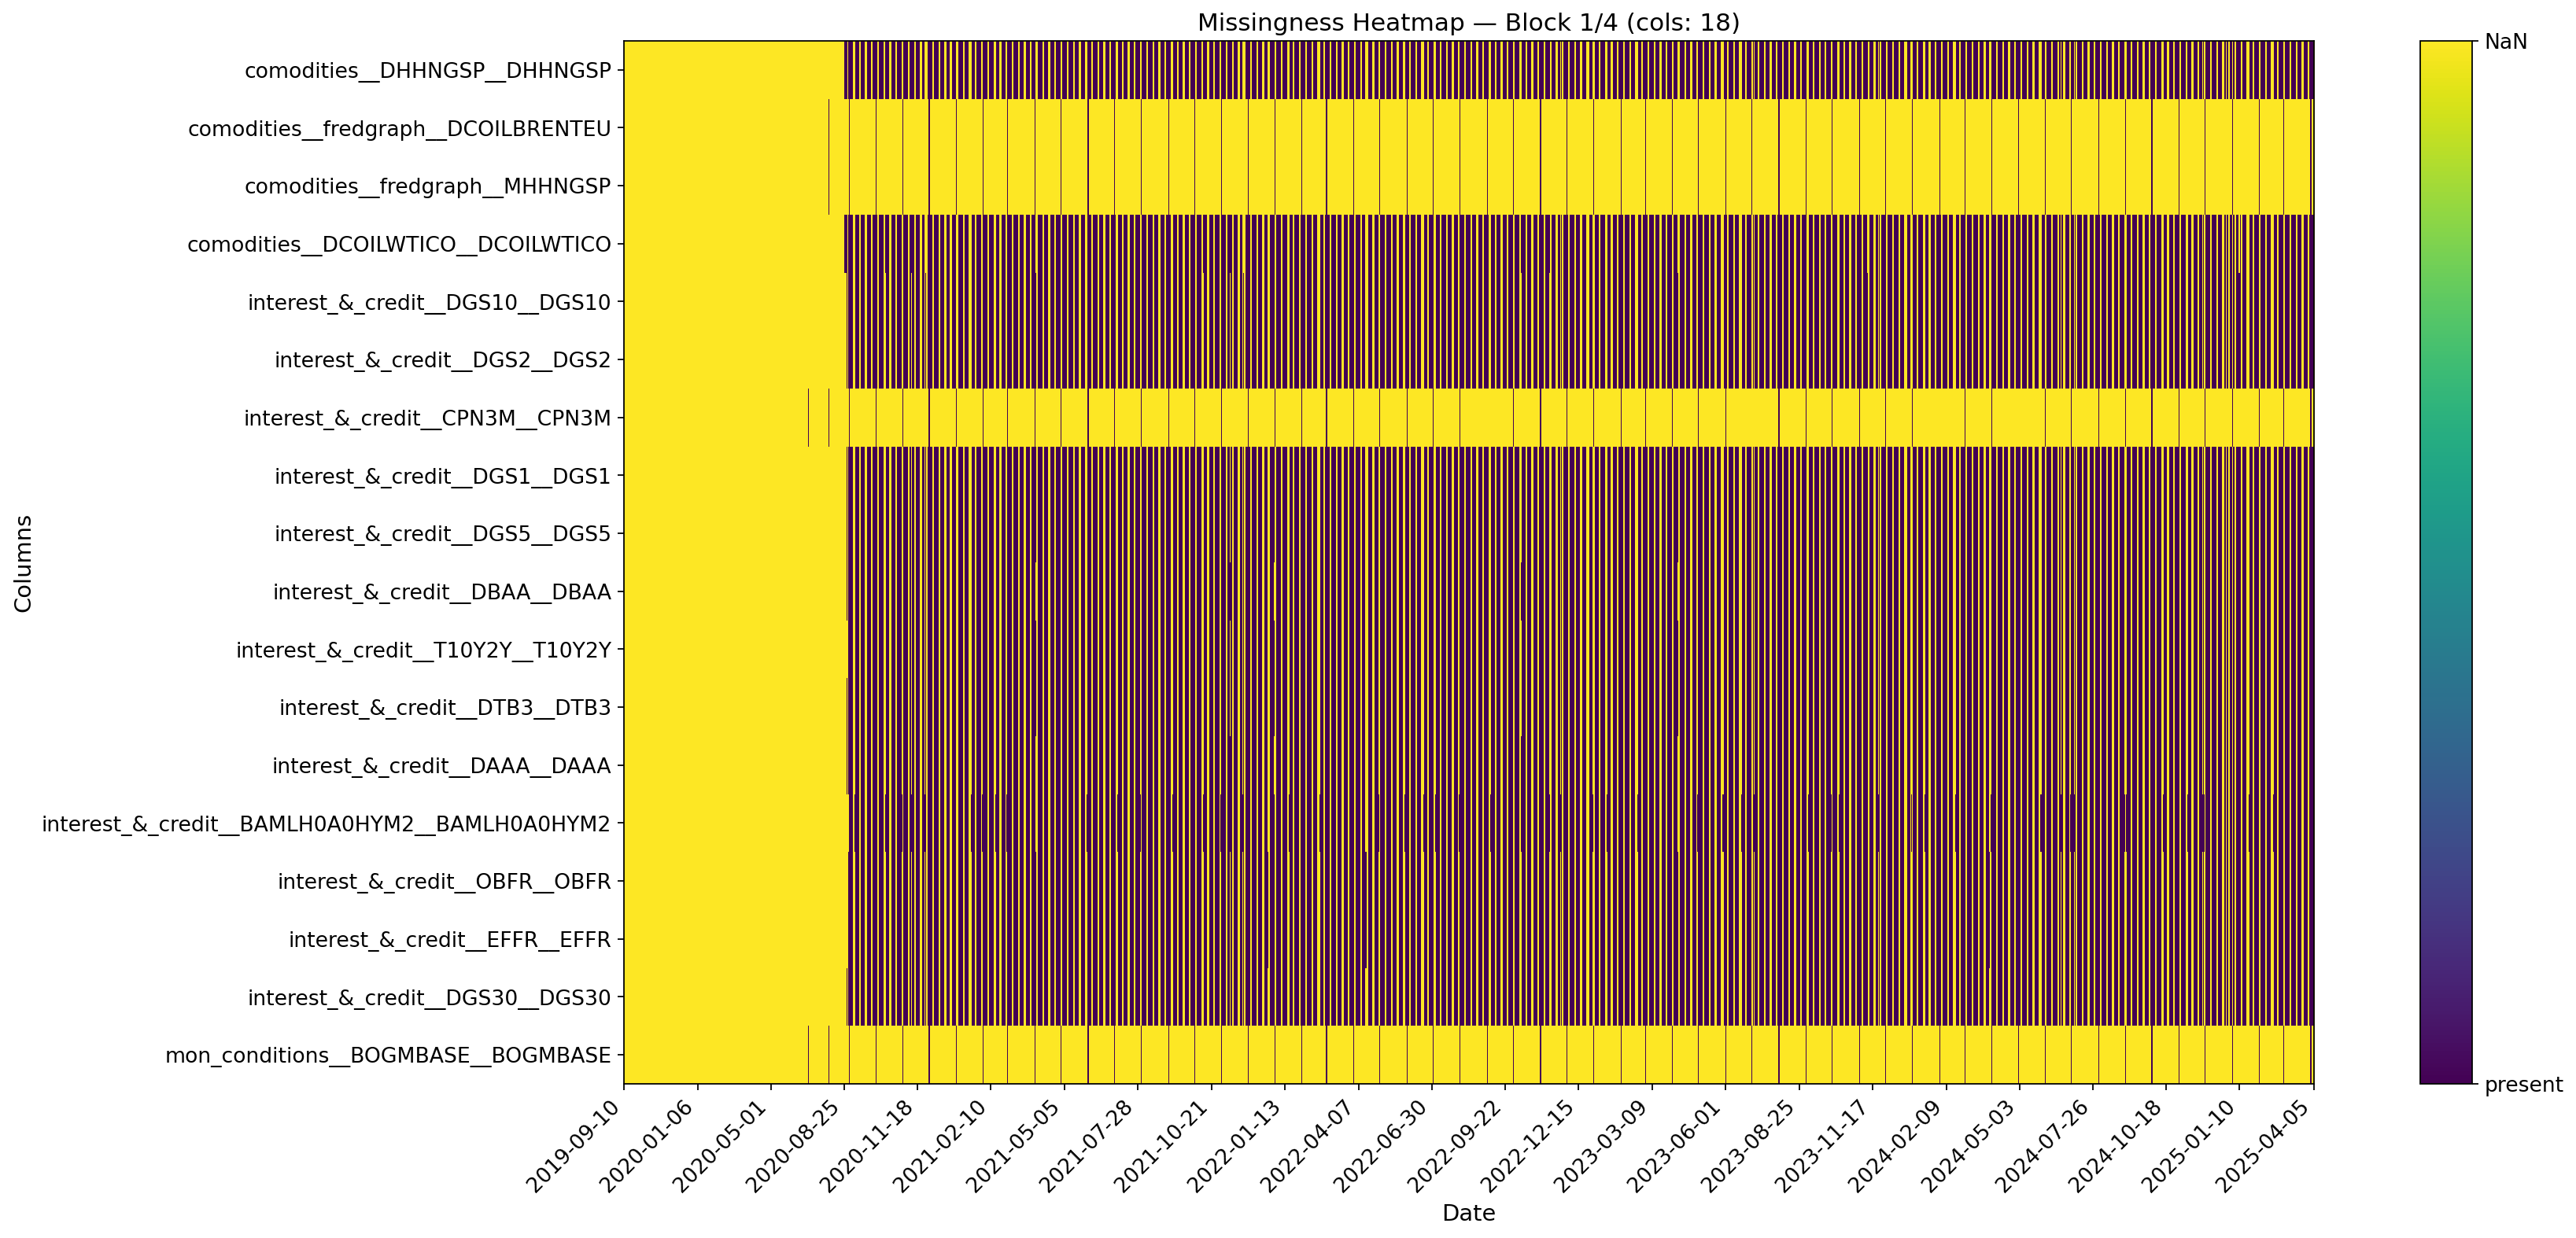

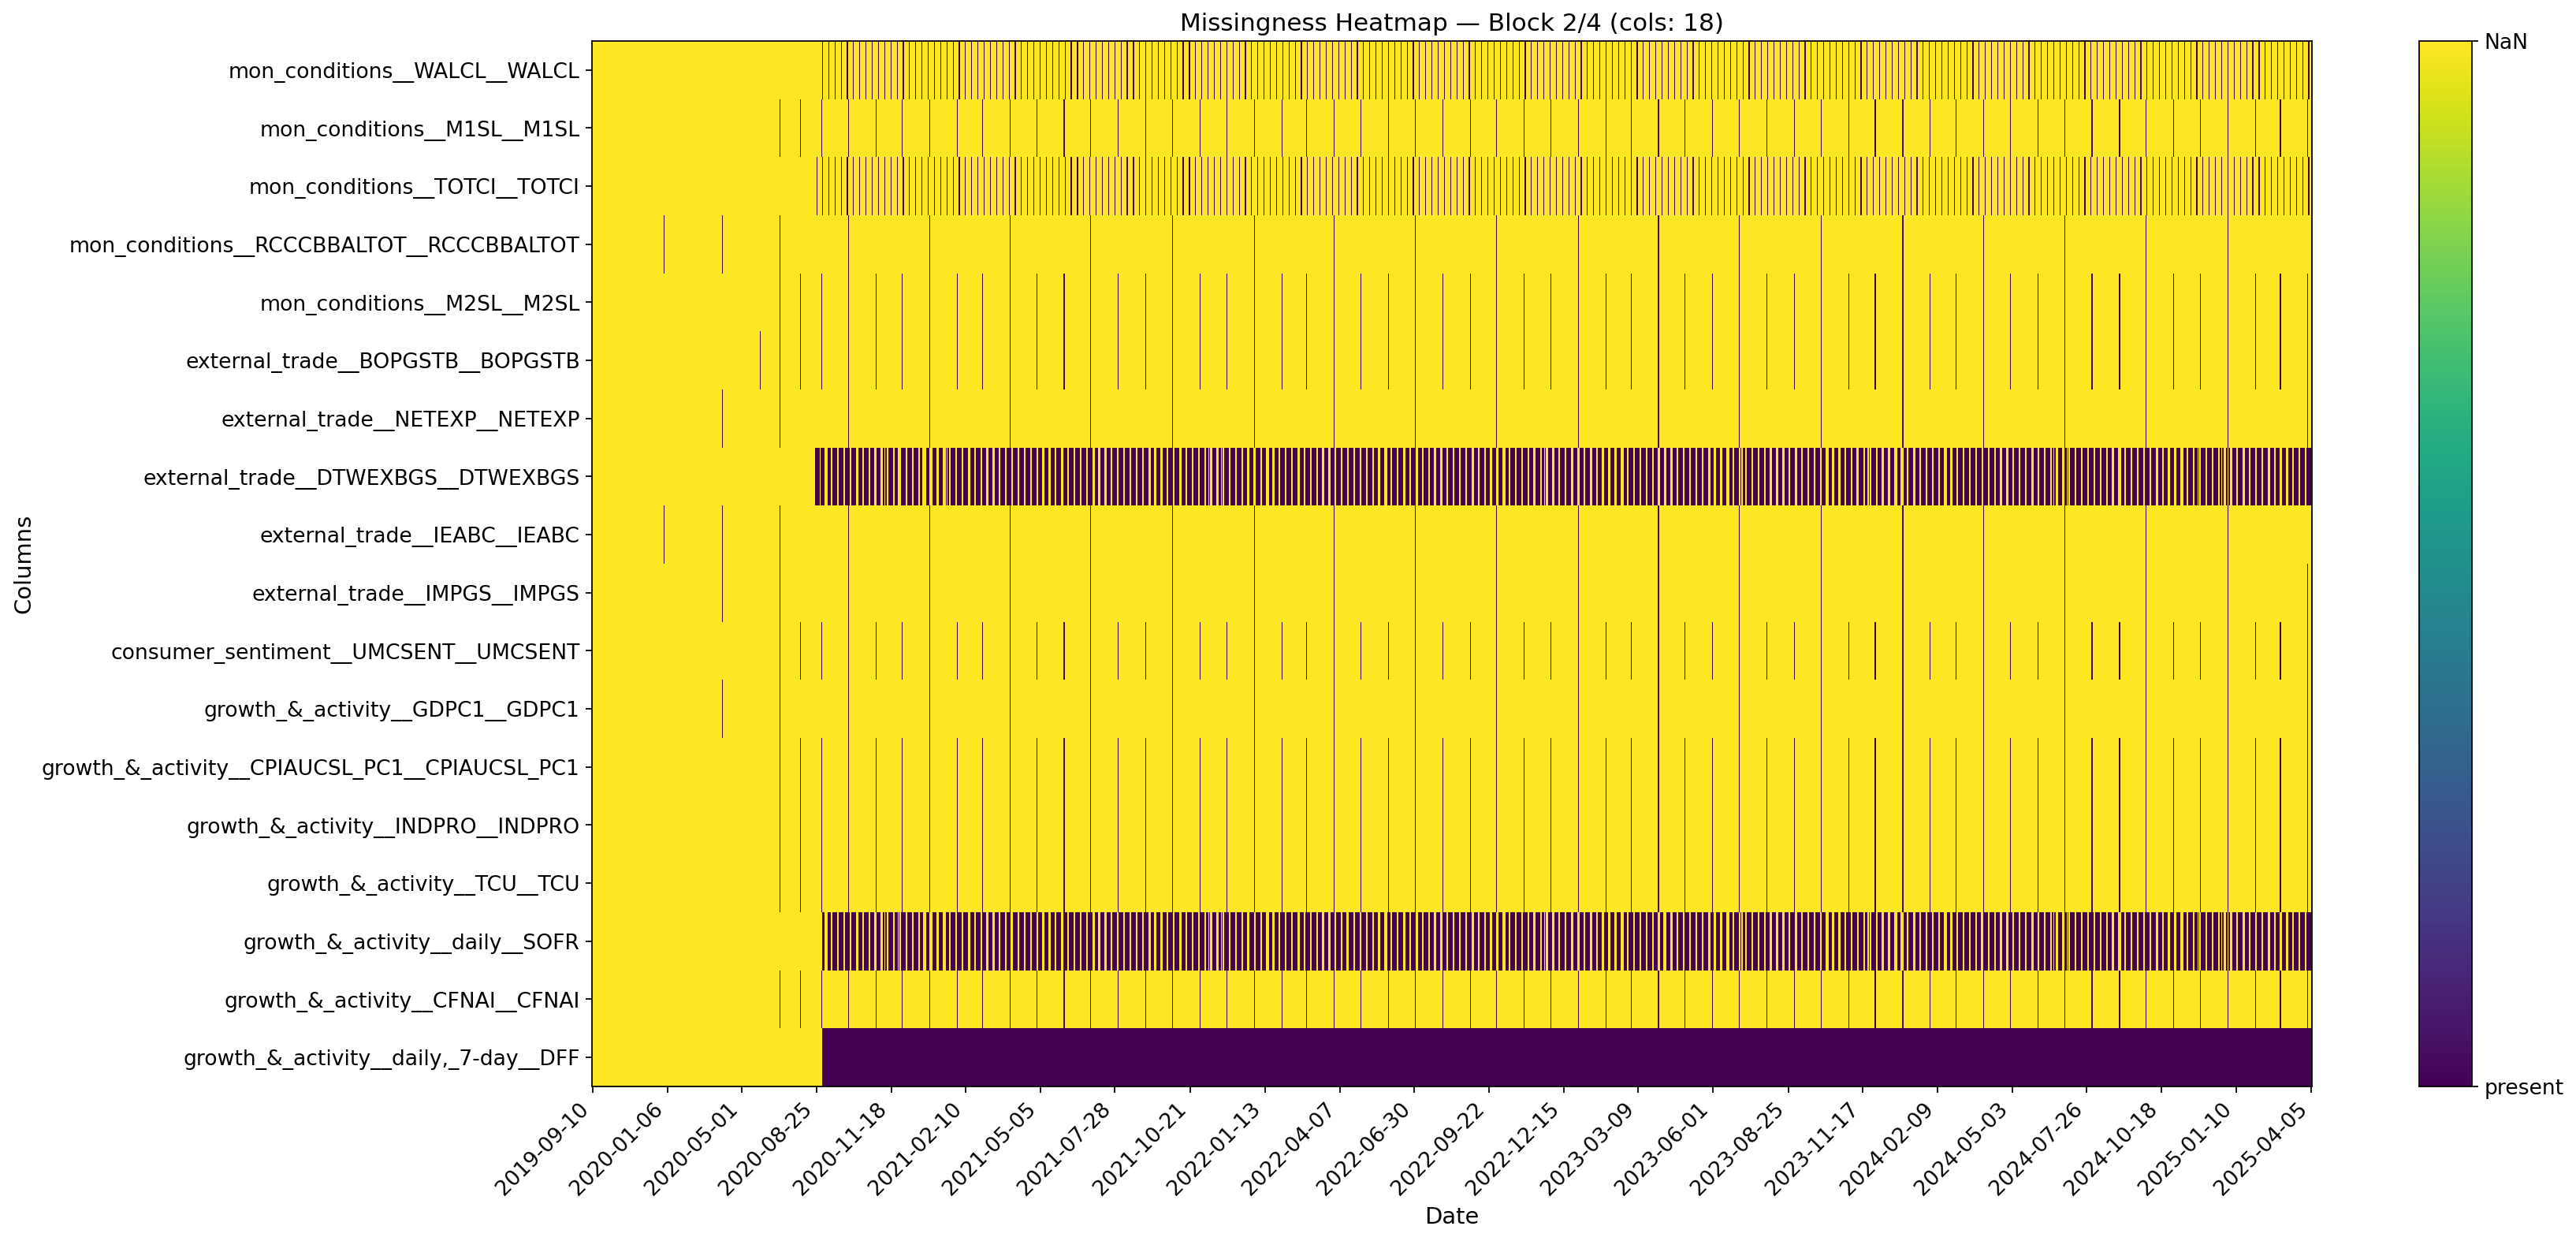

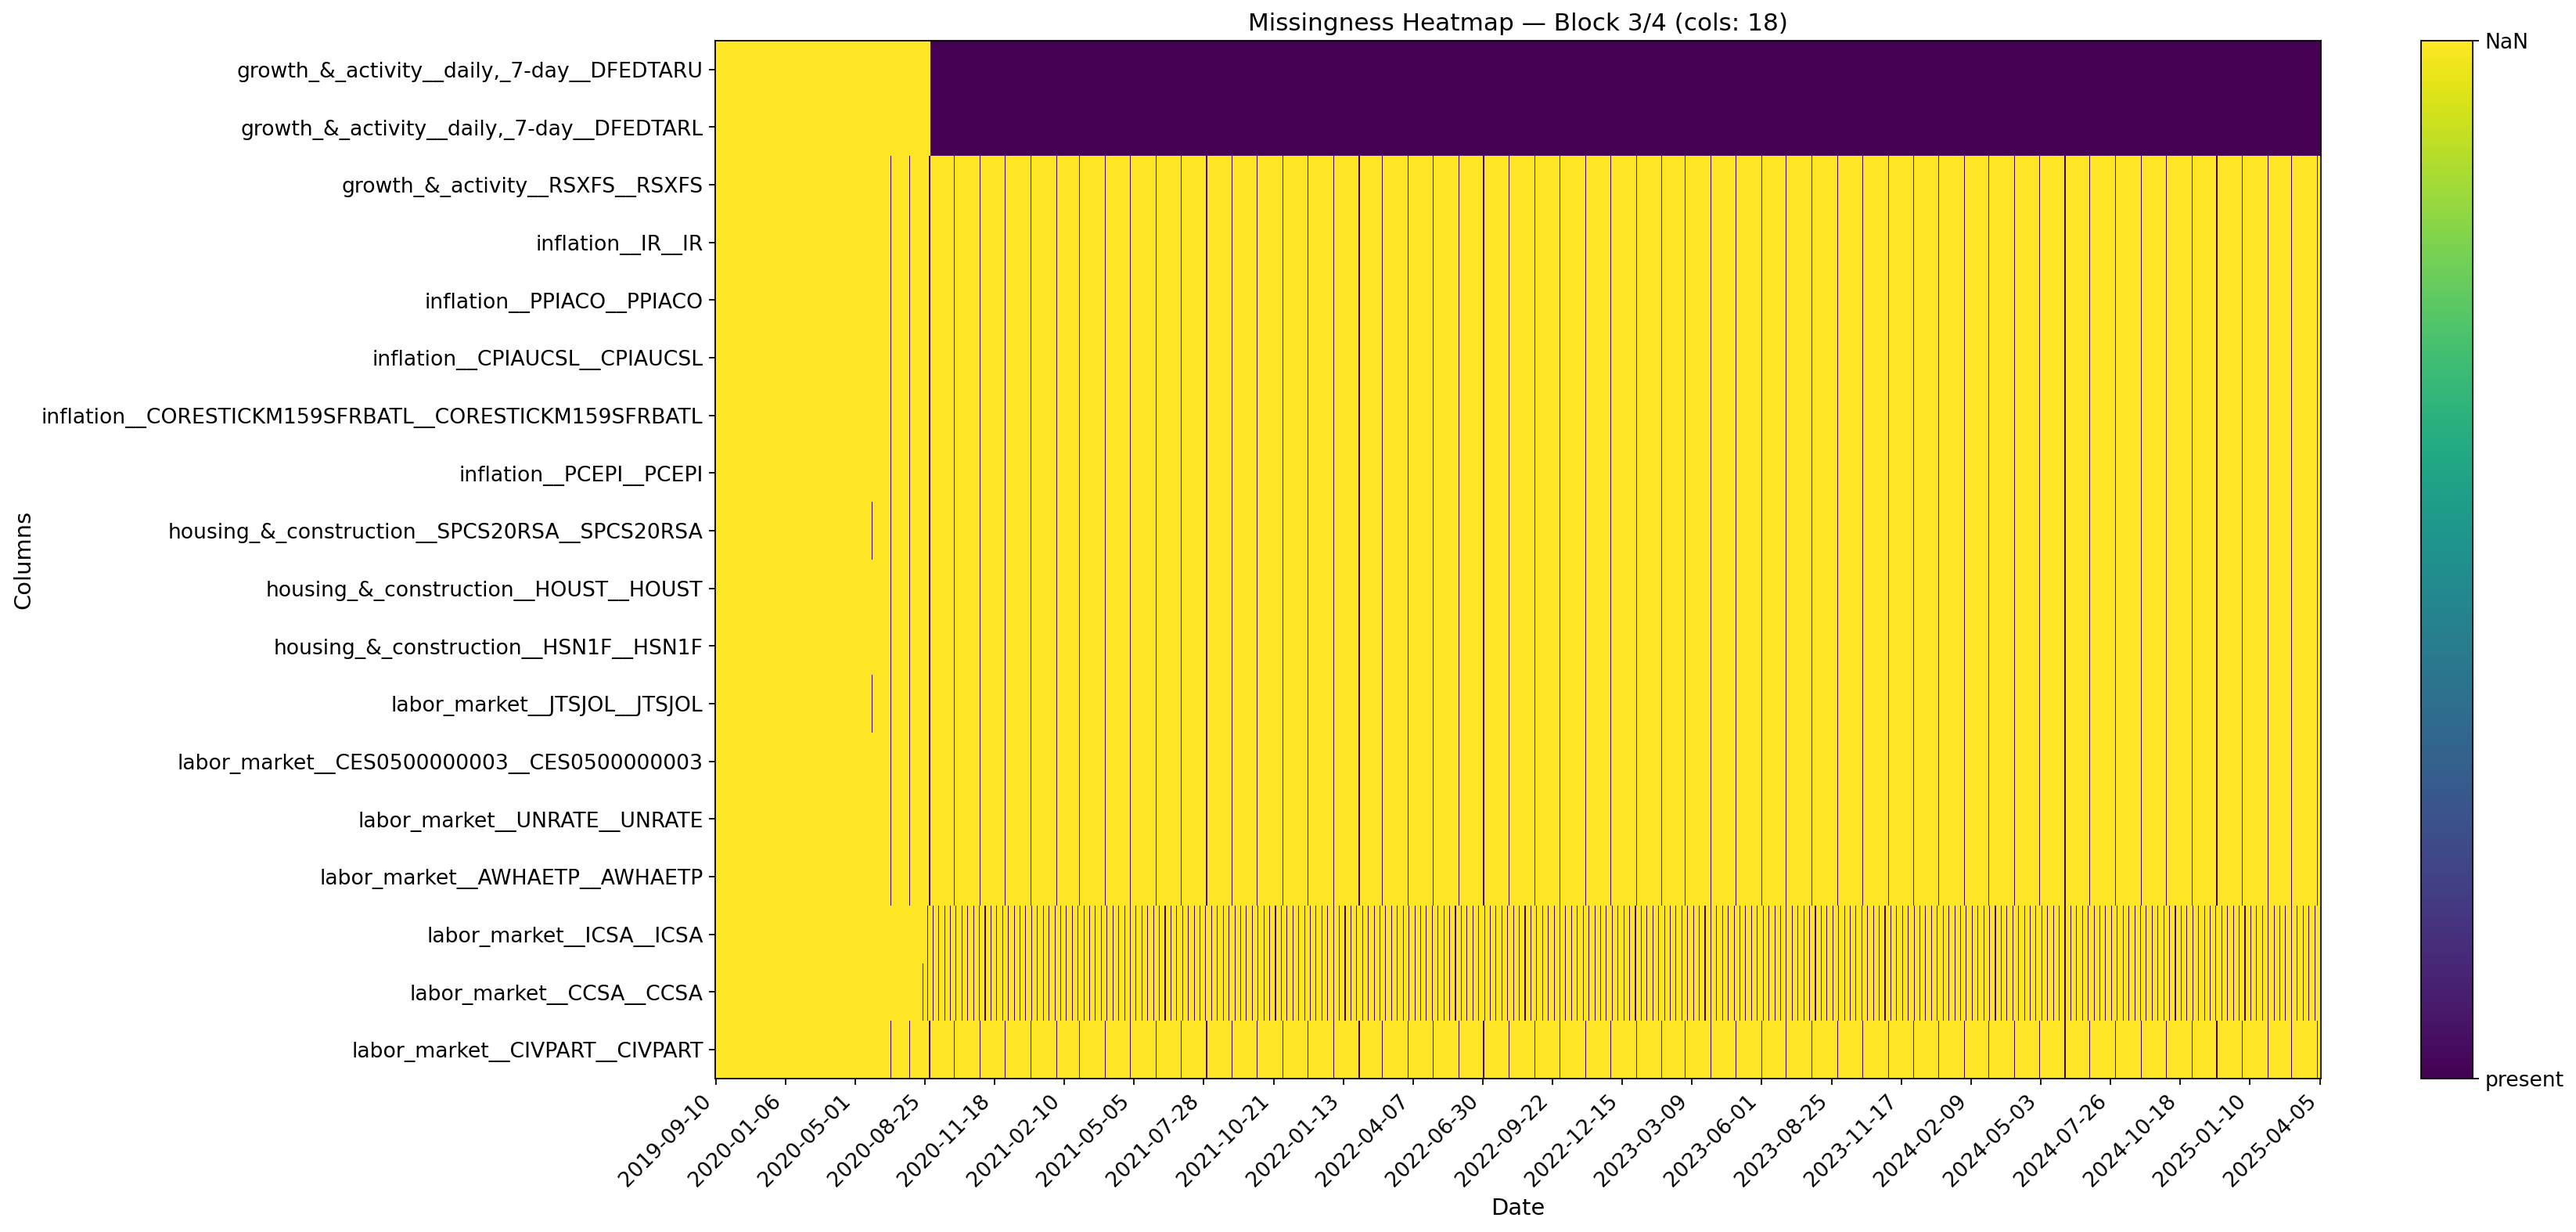

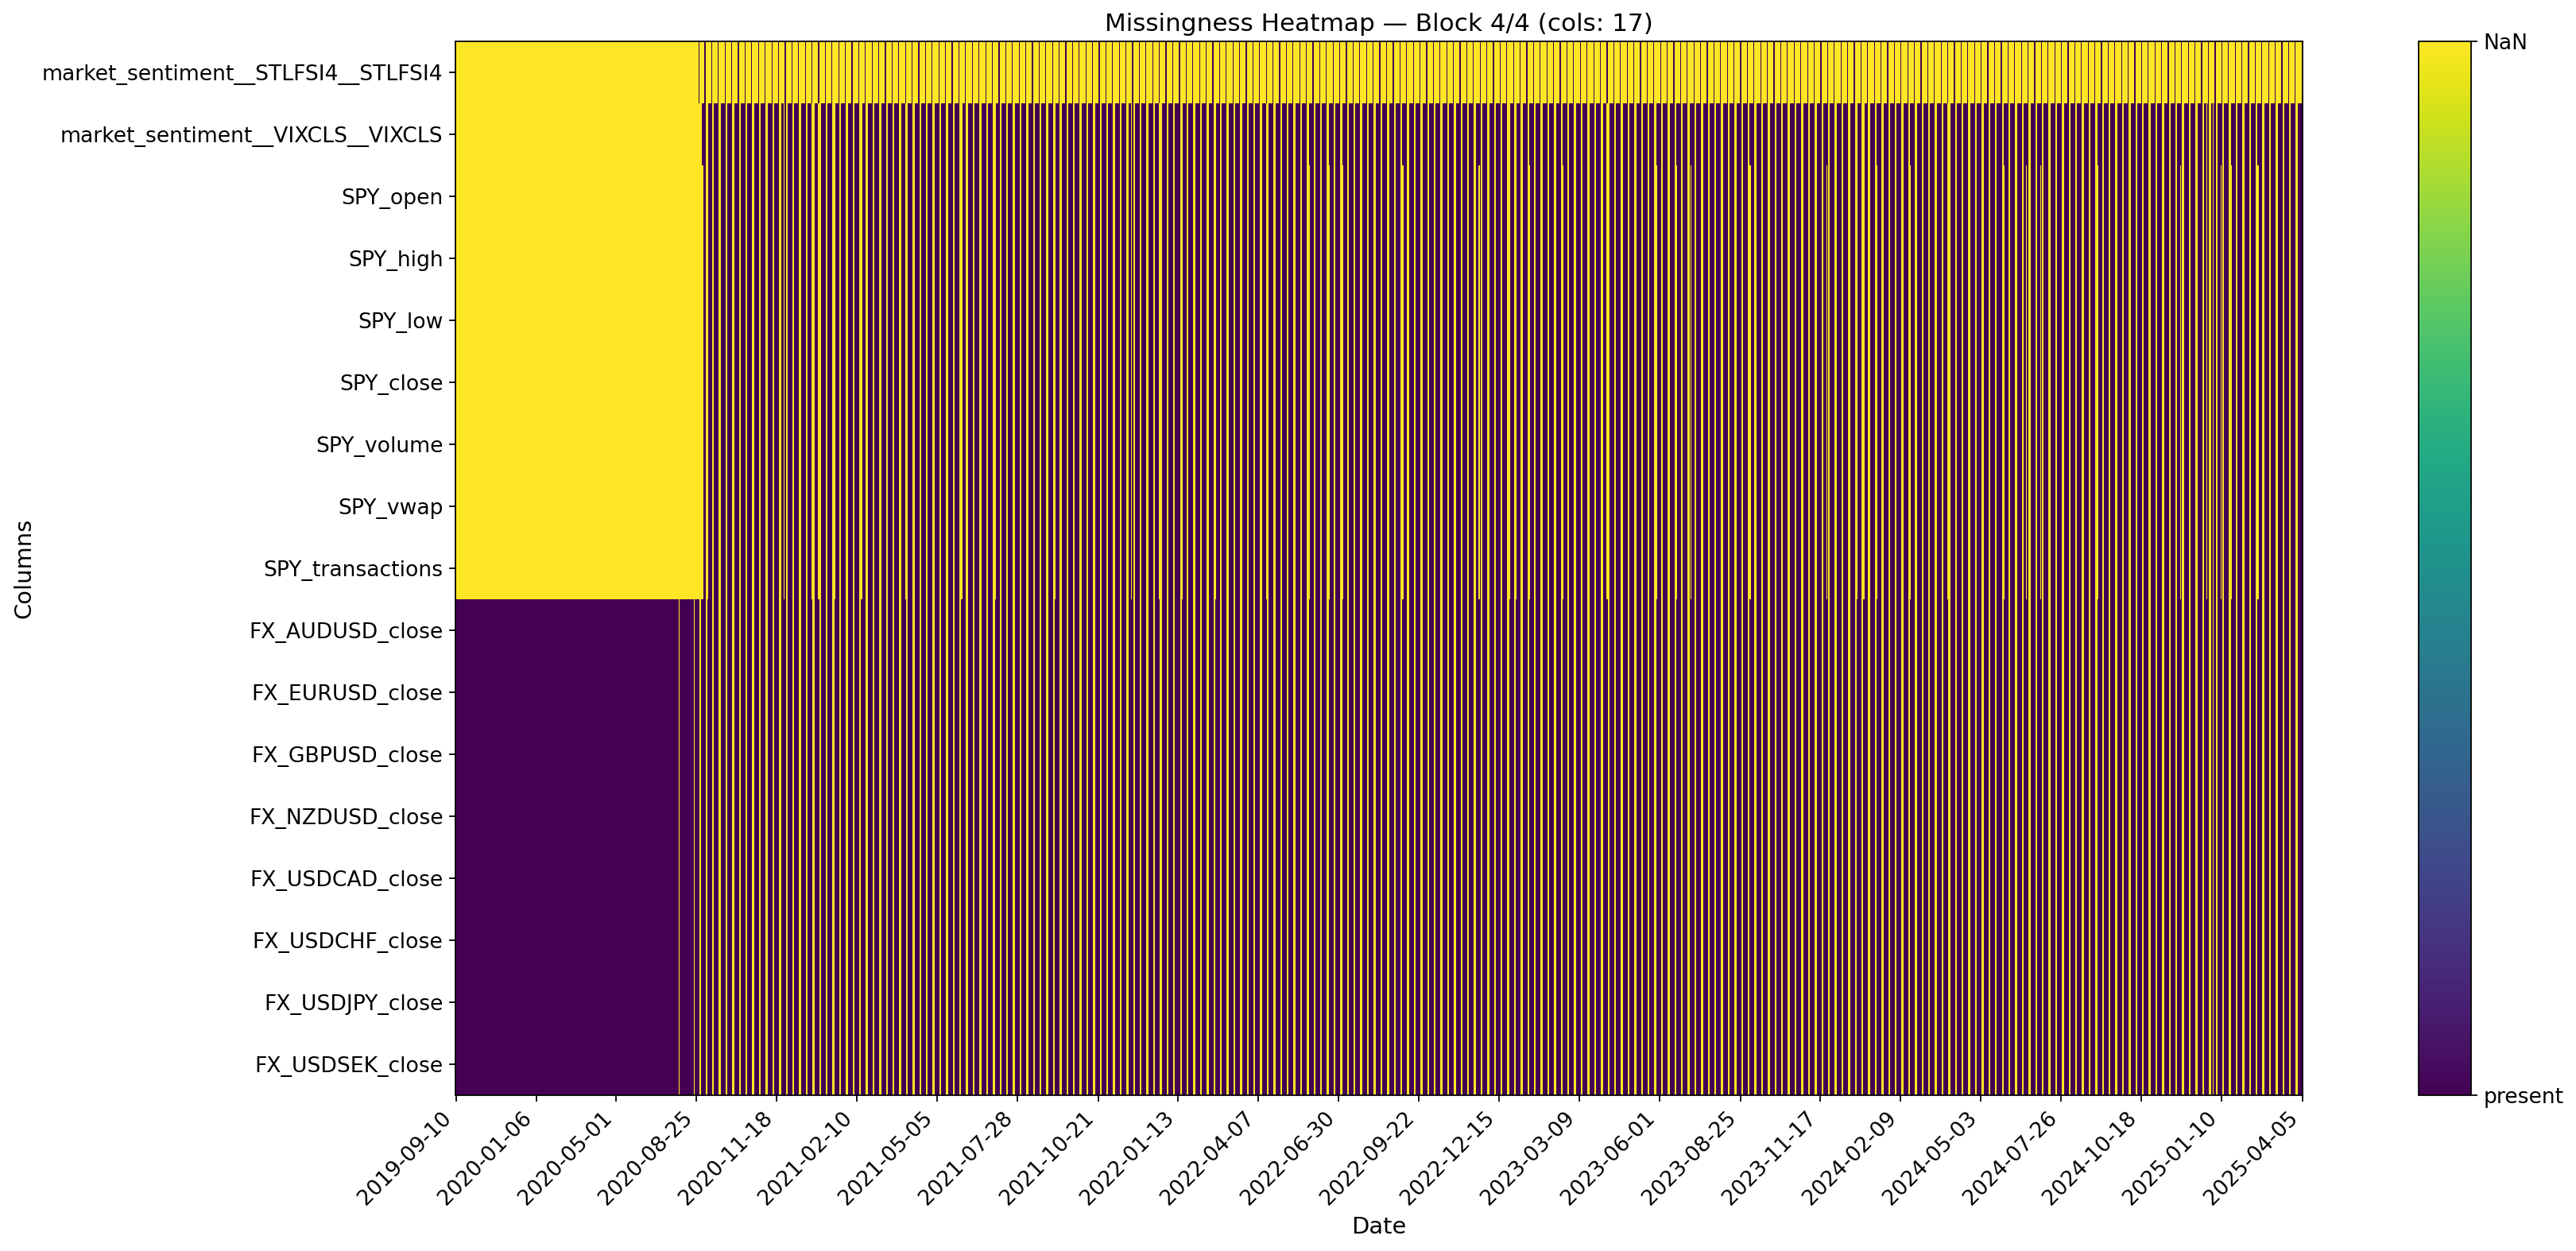

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BLOCKS = 4                     # number of column groups
MAX_XTICKS = 24                # more x ticks for readability
ROW_DOWNSAMPLE = 0             # 0 = no downsample; set to e.g. 2 to take every 2nd row

plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 12

df_plot = df.copy()
if "date" in df_plot.columns:
    df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")
    df_plot = df_plot.dropna(subset=["date"]).set_index("date").sort_index()

mask = df_plot.isna().astype(int)

if ROW_DOWNSAMPLE and ROW_DOWNSAMPLE > 1:
    mask_ds = mask.iloc[::ROW_DOWNSAMPLE, :]
else:
    mask_ds = mask

# split columns into blocks
col_chunks = np.array_split(mask_ds.columns.tolist(), BLOCKS)

for i, cols in enumerate(col_chunks, start=1):
    chunk = mask_ds[cols]
    height = max(10, 0.45 * len(cols))
    plt.figure(figsize=(22, height))  
    plt.imshow(chunk.T, aspect="auto", interpolation="nearest", vmin=0, vmax=1)

    # y ticks = all column names (big figure can handle many)
    plt.yticks(range(len(cols)), cols)

    # x ticks = evenly spaced dates
    num_xticks = min(MAX_XTICKS, len(chunk))
    xtick_pos = np.linspace(0, len(chunk) - 1, num=num_xticks, dtype=int)
    if isinstance(chunk.index, pd.DatetimeIndex):
        xtick_labels = pd.Index(chunk.index[xtick_pos]).strftime("%Y-%m-%d")
    else:
        xtick_labels = chunk.index[xtick_pos].astype(str)
    plt.xticks(xtick_pos, xtick_labels, rotation=45, ha="right")
    plt.tick_params(axis="both", which="major", labelsize=12)

    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Columns", fontsize=13)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["present", "NaN"])
    cbar.ax.tick_params(labelsize=12)

    plt.title(f"Missingness Heatmap — Block {i}/{BLOCKS} (cols: {len(cols)})", fontsize=14)
    plt.tight_layout()
    plt.show()


That looks good, with consitent missingness for each feature up until the cutoff. 

### Step 5: Forward Fill

We want a clean dataset with no missing items, so we will forward fill the data. The forward flling step uses past data to fill nans, so there is no risk of future leaking. 

In [9]:
import pandas as pd

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").drop_duplicates(subset=["date"], keep="last")

cols = [c for c in df.columns if c != "date"]
df[cols] = df[cols].ffill()

print("Forward-filled. Shape:", df.shape)


Forward-filled. Shape: (1936, 72)


Lets check the missingness percents after forward filling. 

In [10]:
total = len(df)
for col in df.columns:
    n_nan = int(df[col].isna().sum())
    pct = (n_nan / total * 100) if total else 0.0
    n_non = total - n_nan
    line = f"{col}: NaNs={n_nan:,}  Non-NaN={n_non:,}  Percent={pct:6.2f}%"
    print(line)

date: NaNs=0  Non-NaN=1,936  Percent=  0.00%
comodities__DHHNGSP__DHHNGSP: NaNs=252  Non-NaN=1,684  Percent= 13.02%
comodities__fredgraph__DCOILBRENTEU: NaNs=234  Non-NaN=1,702  Percent= 12.09%
comodities__fredgraph__MHHNGSP: NaNs=234  Non-NaN=1,702  Percent= 12.09%
comodities__DCOILWTICO__DCOILWTICO: NaNs=252  Non-NaN=1,684  Percent= 13.02%
interest_&_credit__DGS10__DGS10: NaNs=255  Non-NaN=1,681  Percent= 13.17%
interest_&_credit__DGS2__DGS2: NaNs=255  Non-NaN=1,681  Percent= 13.17%
interest_&_credit__CPN3M__CPN3M: NaNs=211  Non-NaN=1,725  Percent= 10.90%
interest_&_credit__DGS1__DGS1: NaNs=255  Non-NaN=1,681  Percent= 13.17%
interest_&_credit__DGS5__DGS5: NaNs=255  Non-NaN=1,681  Percent= 13.17%
interest_&_credit__DBAA__DBAA: NaNs=255  Non-NaN=1,681  Percent= 13.17%
interest_&_credit__T10Y2Y__T10Y2Y: NaNs=257  Non-NaN=1,679  Percent= 13.27%
interest_&_credit__DTB3__DTB3: NaNs=255  Non-NaN=1,681  Percent= 13.17%
interest_&_credit__DAAA__DAAA: NaNs=255  Non-NaN=1,681  Percent= 13.17%


Each of the features contains relatively similar missing percentages. Lets drop nans up to the first row containing zero nans and recheck missingness percent. 

In [11]:
import pandas as pd

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# drop columns that are entirely NaN after that
value_cols = [c for c in df.columns if c != "date"]
all_nan = [c for c in value_cols if not df[c].notna().any()]
if all_nan:
    print("Also dropping all-NaN columns:", all_nan)
    df = df.drop(columns=all_nan)
    value_cols = [c for c in df.columns if c != "date"]

# compute the latest first-valid index across remaining columns
first_idxs = [df[c].first_valid_index() for c in value_cols if df[c].notna().any()]
first_pos = max(first_idxs) if first_idxs else 0

start_before = df.loc[0, "date"]
df = df.loc[first_pos:].reset_index(drop=True)
start_after  = df.loc[0, "date"]

print(f"Start before: {start_before.date()}  ->  Start after: {start_after.date()}  | rows: {len(df)}")



Start before: 2019-09-10  ->  Start after: 2020-09-03  | rows: 1676


We can see most of the padding for the extra year we kept earlier was removed. 

In [12]:
total = len(df)
for col in df.columns:
    n_nan = int(df[col].isna().sum())
    pct = (n_nan / total * 100) if total else 0.0
    n_non = total - n_nan
    line = f"{col}: NaNs={n_nan:,}  Non-NaN={n_non:,}  Percent={pct:6.2f}%"
    print(line)

date: NaNs=0  Non-NaN=1,676  Percent=  0.00%
comodities__DHHNGSP__DHHNGSP: NaNs=0  Non-NaN=1,676  Percent=  0.00%
comodities__fredgraph__DCOILBRENTEU: NaNs=0  Non-NaN=1,676  Percent=  0.00%
comodities__fredgraph__MHHNGSP: NaNs=0  Non-NaN=1,676  Percent=  0.00%
comodities__DCOILWTICO__DCOILWTICO: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DGS10__DGS10: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DGS2__DGS2: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__CPN3M__CPN3M: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DGS1__DGS1: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DGS5__DGS5: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DBAA__DBAA: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__T10Y2Y__T10Y2Y: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DTB3__DTB3: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__DAAA__DAAA: NaNs=0  Non-NaN=1,676  Percent=  0.00%
interest_&_credit__BAMLH0A

Our dataset is now clean. Lets save it to a csv for future use. 

#### Step 6: Save

In [13]:
df.to_csv("../../data/generated/clean_finance_data.csv", index=False)